In [1]:
import pandas as pd
import numpy as np
import glob
import json

from skbio import OrdinationResults
from scipy.stats import kruskal
from gemelli.rpca import joint_rpca
from biom import load_table

#plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
%matplotlib inline

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import 
metadata = pd.read_csv('../network/split-matched-data/metadata.tsv', index_col=0, sep='\t')
tables = {i.split('/')[-1].split('.')[0]:load_table(i) for i in glob.glob('../network/split-matched-data/*') if 'metadata' not in i}

In [4]:
#remove the metabolomics table for reproducibility
#del tables['metabolomics']

In [3]:
print(metadata.shape)
display(metadata.head())

(374, 16)


season subjects  add_0c add_0c_group  \
sample_name                                                                 
soil.hip.CMU.17.10.2017.08.11.day3   summer    17-10   49.75        early   
soil.hip.CMU.17.10.2017.08.22.day14  summer    17-10  322.80     advanced   
soil.hip.CMU.17.10.2017.08.28.day20  summer    17-10  477.80     advanced   
soil.hip.CMU.17.10.2017.08.09.day1   summer    17-10    0.00      initial   
soil.hip.CMU.17.10.2017.08.23.day15  summer    17-10  348.05     advanced   

                                    facility  timepoint traintest_0  \
sample_name                                                           
soil.hip.CMU.17.10.2017.08.11.day3      FIRS          3       train   
soil.hip.CMU.17.10.2017.08.22.day14     FIRS         14        test   
soil.hip.CMU.17.10.2017.08.28.day20     FIRS         20        test   
soil.hip.CMU.17.10.2017.08.09.day1      FIRS          1       train   
soil.hip.CMU.17.10.2017.08.23.day15     FIRS         15       train   

                                    traintest_1 traintest_2 traintest_3  \
sample_name                                                               
soil.hip.CMU.17.10.2017.08.11.day3        train       train       train   
soil.hip.CMU.17.10.2017.08.22.day14        test        test        test   
soil.hip.CMU.17.10.2017.08.28.day20        test        test        test   
soil.hip.CMU.17.10.2017.08.09.day1        train       train       train   
soil.hip.CMU.17.10.2017.08.23.day15       train       train       train   

                                    traintest_4 traintest_5 traintest_6  \
sample_name                                                               
soil.hip.CMU.17.10.2017.08.11.day3        train       train       train   
soil.hip.CMU.17.10.2017.08.22.day14        test        test        test   
soil.hip.CMU.17.10.2017.08.28.day20        test        test        test   
soil.hip.CMU.17.10.2017.08.09.day1        train       train       train   
soil.hip.CMU.17.10.2017.08.23.day15       train       train       train   

                                    traintest_7 traintest_8 traintest_9  
sample_name                                                              
soil.hip.CMU.17.10.2017.08.11.day3        train       train       train  
soil.hip.CMU.17.10.2017.08.22.day14        test        test        test  
soil.hip.CMU.17.10.2017.08.28.day20        test        test        test  
soil.hip.CMU.17.10.2017.08.09.day1        train       train       train  
soil.hip.CMU.17.10.2017.08.23.day15       train       train       train

In [4]:
# check which body sites are present
# id_split_lst = []
# for id in metadata.index:
#     id_split = ('.').join(id.split('.')[0:3])
#     id_split_lst.append(id_split)
    
# metadata['id_site'] = id_split_lst

## pre-filter tables (optional)

In [4]:
#first load features to be removed from each omic
with open('../results/joint-rpca/rf_top_feats_to_remove.json') as json_file:
    feats_to_remove = json.load(json_file)

In [5]:
tables_filtered = tables.copy()
#remove omics not used in the analysis
del tables_filtered['metabolomics']
del tables_filtered['16S']

In [6]:
#print number of features to be removed
for omic in tables_filtered.keys():
    print(omic, len(feats_to_remove[omic]))

metabolite 460
mag 47
18S 905
gene_module 70
gene 448


In [7]:
for omic in tables_filtered.keys():
    #before filtering
    print(omic, tables_filtered[omic].shape)
    tables_filtered[omic] = tables_filtered[omic].filter(feats_to_remove[omic], axis='observation', invert=True)
    #after filtering
    print(omic, tables_filtered[omic].shape)

metabolite (2333, 374)
metabolite (1873, 374)
mag (257, 374)
mag (210, 374)
18S (5473, 374)
18S (4568, 374)
gene_module (377, 374)
gene_module (307, 374)
gene (2457, 374)
gene (2009, 374)


## functions

In [4]:
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'

def ordination_scatterplots(rpca_results, metadata, x="PC1", y="PC2",
                            hue=None, hue_order=None, palette="tab10", 
                            markers=None, style=None, style_order=None, 
                            colorbar=False, cbar_label=None, point_size=100, 
                            subplots=(2,3), figsize=(25, 10),
                            save_fig=False, save_path=None):

    if subplots is not None:
        fig, axn = plt.subplots(subplots[0], subplots[1], figsize=figsize)
        axn = axn.flatten()
    else:
        fig = plt.figure(figsize=figsize)
        axn = [plt.gca()]

    omic_title = {'18S': '18S', '16S': '16S', 'mag': 'MAG', 'gene': 'Gene',
                  'gene_module': 'Gene Module', 'metabolite': 'Metabolite',
                  'joint': 'Joint-RPCA'}

    for ax, (tblid, (ord_, _, _)) in zip(axn, rpca_results.items()):
        #prepare dataframe
        ord_samples = ord_.samples.rename(columns={0:'PC1', 1:'PC2', 
                                                   2:'PC3', 3:'PC4'})
        ord_plt = pd.concat([ord_samples, metadata], axis=1, sort=True)

        #plotting
        sns.scatterplot(x=x, y=y, hue=hue, hue_order=hue_order, 
                        palette=palette, style=style, 
                        style_order=style_order, markers=markers, 
                        data=ord_plt, s=point_size, ax=ax)
        ax.set_xlabel(x, color='black', weight='bold', fontsize=22)
        ax.set_ylabel(y, color='black', weight='bold', fontsize=22)
        ax.set_title(omic_title[tblid], color='black', weight='bold', fontsize=22)
        
        #fix backround
        ax.set_facecolor('white')
        ax.set_axisbelow(True)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['top'].set_visible(False)
        for child in ax.get_children():
            if isinstance(child, matplotlib.spines.Spine):
                child.set_color('grey')

        for tick in ax.get_yticklabels():
            tick.set_fontproperties('arial')
            tick.set_weight('bold')
            tick.set_color("black")
            tick.set_fontsize(14)
    
        for tick in ax.get_xticklabels():
            tick.set_fontproperties('arial')
            tick.set_weight('bold')
            tick.set_color("black")
            tick.set_fontsize(14)
        
        hue_dtype = metadata[hue].dtype
        if (hue_dtype!='float64') and (hue_dtype!='int64'):
            ax.legend_.remove()
        
        if (subplots is not None) and (colorbar):
            norm = plt.Normalize(metadata[hue].min(), metadata[hue].max())
            sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
            sm.set_array([])
            ax.legend_.remove()
            cbar = ax.figure.colorbar(sm, location='right', shrink=0.8,
                                      anchor=(0.0, 0.5), ax=ax)
            cbar.ax.tick_params(labelsize=16)
            cbar.set_label(cbar_label, labelpad=-70, y=0.5, 
                           fontsize=20, weight='bold')
            
    plt.tight_layout()

    if (subplots is not None) and (colorbar == False):
        ncats = metadata[hue].nunique()
        legend = ax.legend(loc=2, bbox_to_anchor=(-1.1, 2.6),
                           prop={'size':22}, title="",
                           fancybox=True, framealpha=.0,
                           ncol=ncats, markerscale=3.5)
        legend.get_title().set_fontsize('16')
        #increase the line width in the legend 
        for line in legend.get_lines()[:]:
            line.set_linewidth(2.0)
        for line in legend.get_lines()[:]:
            line.set_linewidth(2.0)
    
    elif (subplots is None) and (colorbar == False):
        legend = ax.legend(loc=2, bbox_to_anchor=(1, 1),
                           prop={'size':18}, title="",
                           fancybox=True, framealpha=.0,
                           ncol=1, markerscale=3.5)
        legend.get_title().set_fontsize('16')
        #increase the line width in the legend 
        for line in legend.get_lines()[:]:
            line.set_linewidth(2.0)
        for line in legend.get_lines()[:]:
            line.set_linewidth(2.0)

    if (colorbar) and (subplots is None):
        norm = plt.Normalize(metadata[hue].min(), metadata[hue].max())
        sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
        sm.set_array([])

        # Remove the legend and add a colorbar
        ax.get_legend().remove()
        cbar = ax.figure.colorbar(sm, location='right', shrink=0.8,
                                  anchor=(0.0, 0.5), ax=axn[-1])
        cbar.ax.tick_params(labelsize=14)
        cbar.set_label(cbar_label, labelpad=-65, y=0.5, 
                       fontsize=20, weight='bold')

    if save_fig:
        plt.savefig(save_path, dpi=600, bbox_inches='tight', format='pdf')
        
    plt.show()

In [5]:
def ord_scatter_3D(rpca_results, metadata, 
                   hue, hue_order, 
                   pcs=["PC1","PC2","PC3"], palette="tab10", 
                   subplots=(2,3), figsize=(25, 10)):

    if subplots is not None:
        fig, axn = plt.subplots(subplots[0], subplots[1], figsize=figsize,
                                subplot_kw=dict(projection='3d'))
        axn = axn.flatten()
    else:
        ax = plt.figure(figsize=figsize).add_subplot(projection='3d')
        axn = [ax]

    for ax, (tblid, (ord_, _, _)) in zip(axn, rpca_results.items()):
        #prepare dataframe
        ord_samples = ord_.samples.rename(columns={0:'PC1', 1:'PC2', 
                                                   2:'PC3', 3:'PC4'})
        ord_plt = pd.concat([ord_samples, metadata], axis=1, sort=True)
        #assign colors
        if hue_order is None:
            c = ord_plt[hue]
            cmap = palette
            patches = []
            ncol = 1
        else:
            cmap = None
            color_dict = dict(zip(hue_order, palette))
            ord_plt['Color'] = ord_plt[hue].map(color_dict)
            c = ord_plt['Color']
            patches = [mpatches.Patch(color=value, label=key) for 
                       key, value in color_dict.items()]
            ncol = len(hue_order)

        ax.scatter(xs=ord_plt[pcs[0]], ys=ord_plt[pcs[1]],  
                   zs=ord_plt[pcs[2]], c=c, marker='o', cmap=cmap)

        ax.set_xlabel(pcs[0], color='black', weight='bold', fontsize=15)
        ax.set_ylabel(pcs[1], color='black', weight='bold', fontsize=15)
        ax.set_zlabel(pcs[2], color='black', weight='bold', fontsize=15)
        ax.set_title(tblid, color='black', weight='bold', fontsize=15)

        ax.xaxis.labelpad = 10
        ax.yaxis.labelpad = 15
        ax.zaxis.labelpad = 15
        
        # fix backround
        ax.set_facecolor('white')
        ax.set_axisbelow(True)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['top'].set_visible(False)
        for child in ax.get_children():
            if isinstance(child, matplotlib.spines.Spine):
                child.set_color('grey')

    if subplots is not None:
        legend = ax.legend(handles=patches, loc=9, title='', prop={'size':18},
                           bbox_to_anchor=(-0.9, 2.5), fancybox=True, framealpha=.0,
                           ncol=ncol, markerscale=3.5)
        legend.get_title().set_fontsize('16')
        # increase the line width in the legend 
        for line in legend.get_lines()[:]:
            line.set_linewidth(2.0)
        for line in legend.get_lines()[:]:
            line.set_linewidth(2.0)
        fig.subplots_adjust(wspace=-0.5, hspace=0.2)
    
    else:
        legend = ax.legend(handles=patches, loc=2, bbox_to_anchor=(1.05, 1.1),
                           title='', prop={'size':18}, fancybox=True, framealpha=.0,
                           ncol=1, markerscale=3.5)
        legend.get_title().set_fontsize('16')

        # increase the line width in the legend 
        for line in legend.get_lines()[:]:
            line.set_linewidth(2.0)
        for line in legend.get_lines()[:]:
            line.set_linewidth(2.0)
    
    #plt.tight_layout()
    plt.show()

## independent RPCA

In [6]:
n_PCS = 3

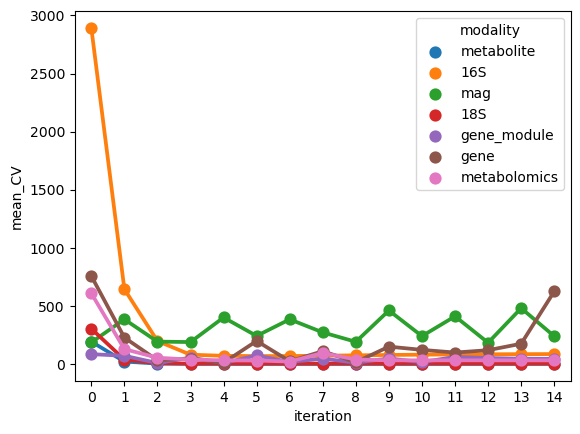

In [11]:
# # ONLY RUN ON FIRST ITERATION
# # check indpendent analysis
# fold = 0
# rpca_independent = {tblid:joint_rpca([tbl], n_components=n_PCS, max_iterations=15,
#                                      min_feature_count=10, sample_metadata=metadata,
#                                      train_test_column='traintest_%i' % fold)
#                     for tblid, tbl in tables.items()}

# cvs_ind = {(fold, datatype_):cv_tmp_dt for datatype_, (_, _, cv_tmp_dt) in rpca_independent.items()}
# cvs_ind_all = pd.concat(cvs_ind).reset_index().rename({'level_0':'fold', 'level_1':'modality'}, axis=1)
# sns.pointplot(x='iteration', y='mean_CV', hue='modality', data=cvs_ind_all)
# plt.show()

In [14]:
# # save results
# for tblid, (ord_, dist_, _) in rpca_independent.items():    
#    ord_.write('../results/joint-rpca/Ordinations/%s_ord_4PCs.txt' % tblid)
#    dist_.write('../results/joint-rpca/Ordinations/%s_dist_4PCs.txt' % tblid)

In [7]:
# load results from prior run
omic_ids = ['metabolite', '16S', 'mag', '18S', 'gene_module', 'gene', 'metabolomics']
rpca_independent = {omic: (OrdinationResults.read('../results/joint-rpca/Original/{}_ord.txt'.format(omic)),
                           None, ##we don't really need the distance matrix for the analysis here! 
                           None) for omic in omic_ids}

### 2D and 3D Scatterplots

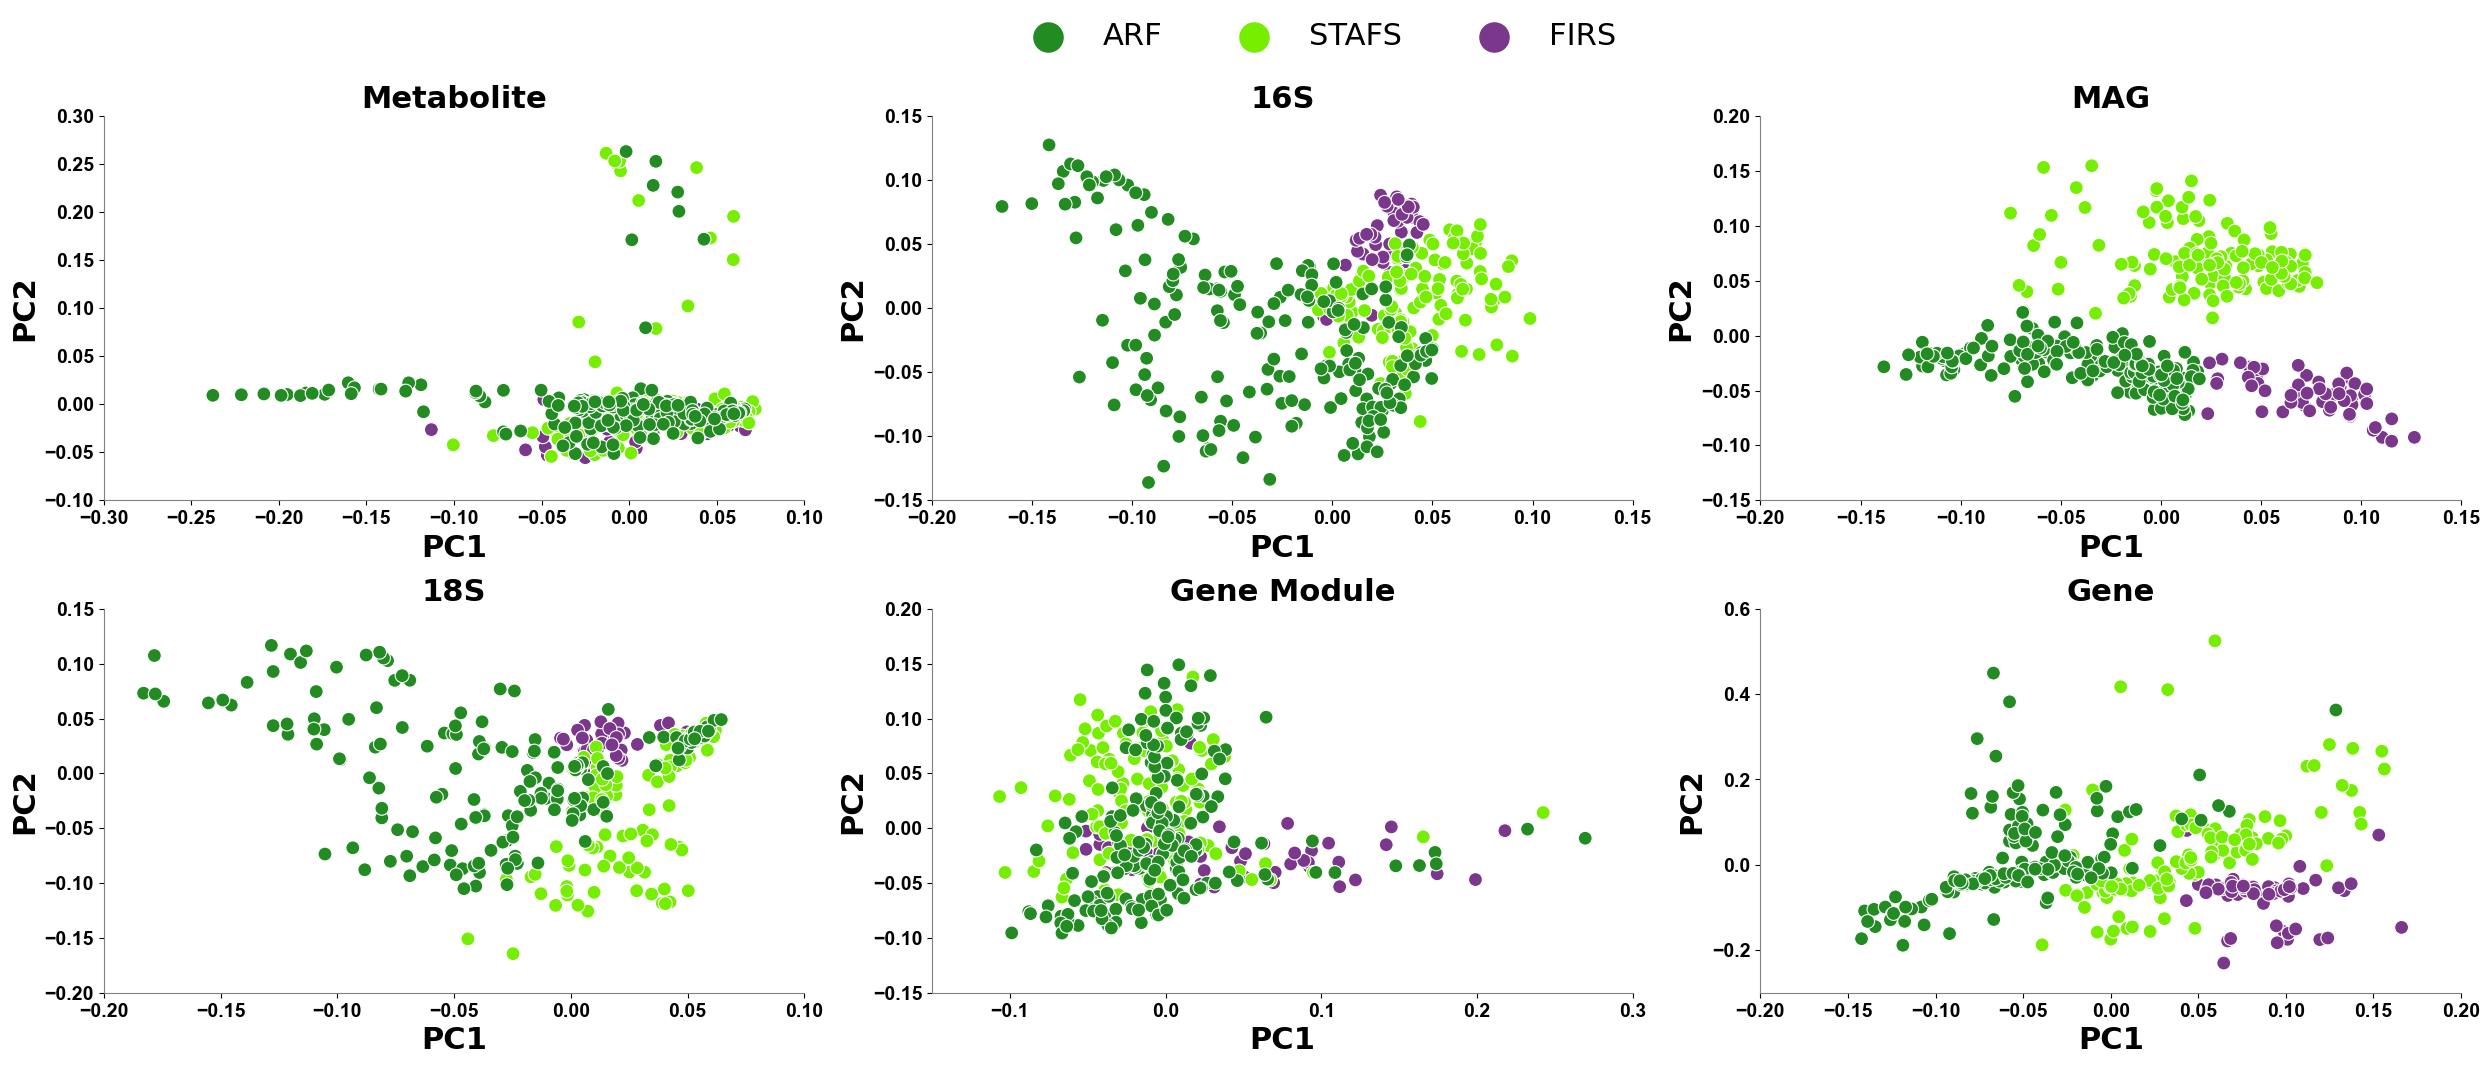

In [8]:
ordination_scatterplots(rpca_independent, metadata, 
                        hue="facility", hue_order=['ARF', 'STAFS', 'FIRS'], 
                        x="PC1", y="PC2", palette=["#228b22","#76ee00","#7a378b"], 
                        subplots=(2,3), save_fig=True, figsize=(25, 10),
                        save_path='../results/joint-rpca/figures/rpca-ord-facility-scatter.pdf')

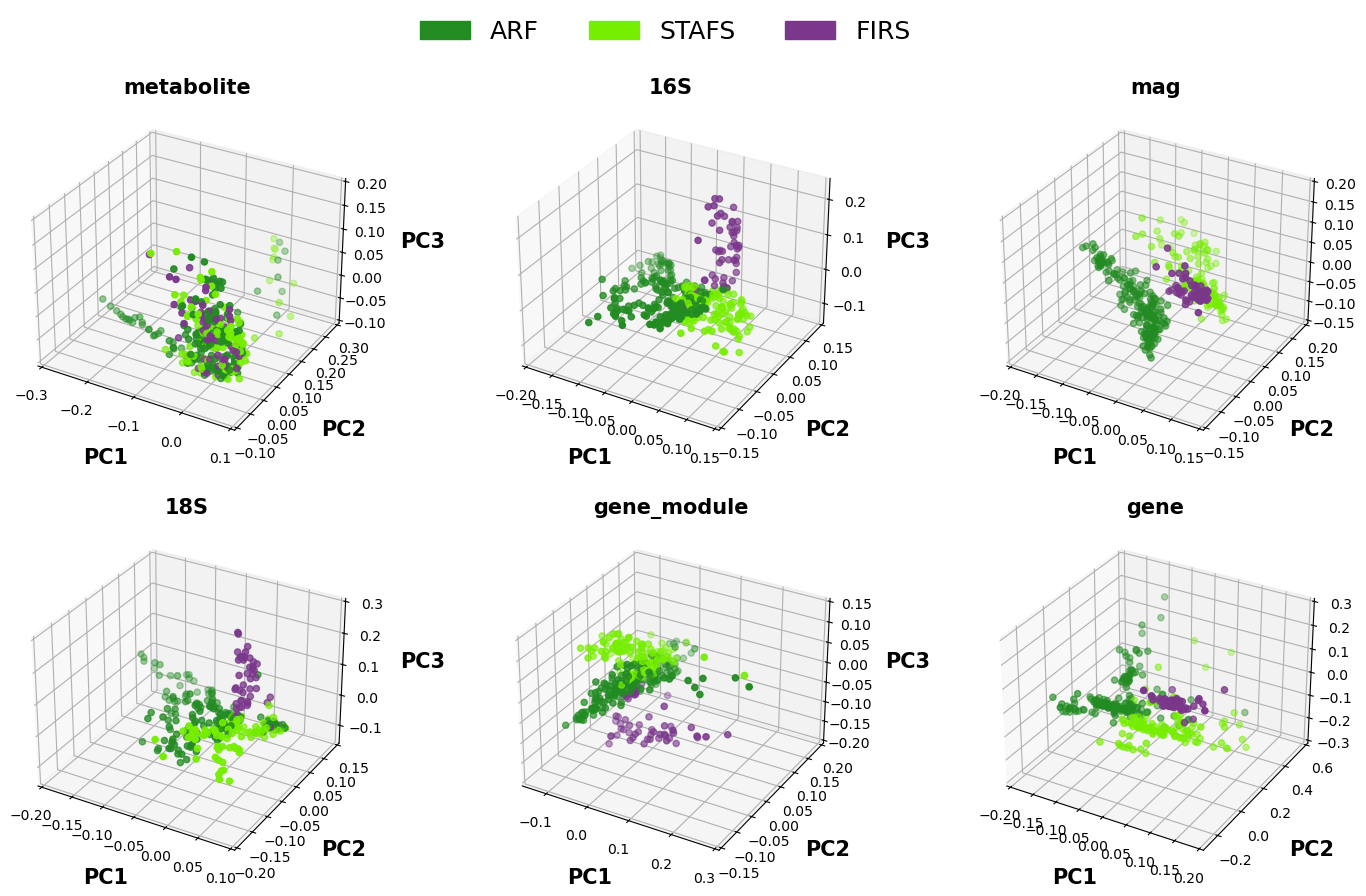

In [9]:
ord_scatter_3D(rpca_independent, metadata, 
               hue="facility", hue_order=['ARF', 'STAFS', 'FIRS'], 
               pcs=["PC1","PC2","PC3"], palette=["#228b22","#76ee00","#7a378b"], 
               subplots=(2,3), figsize=(25, 10))

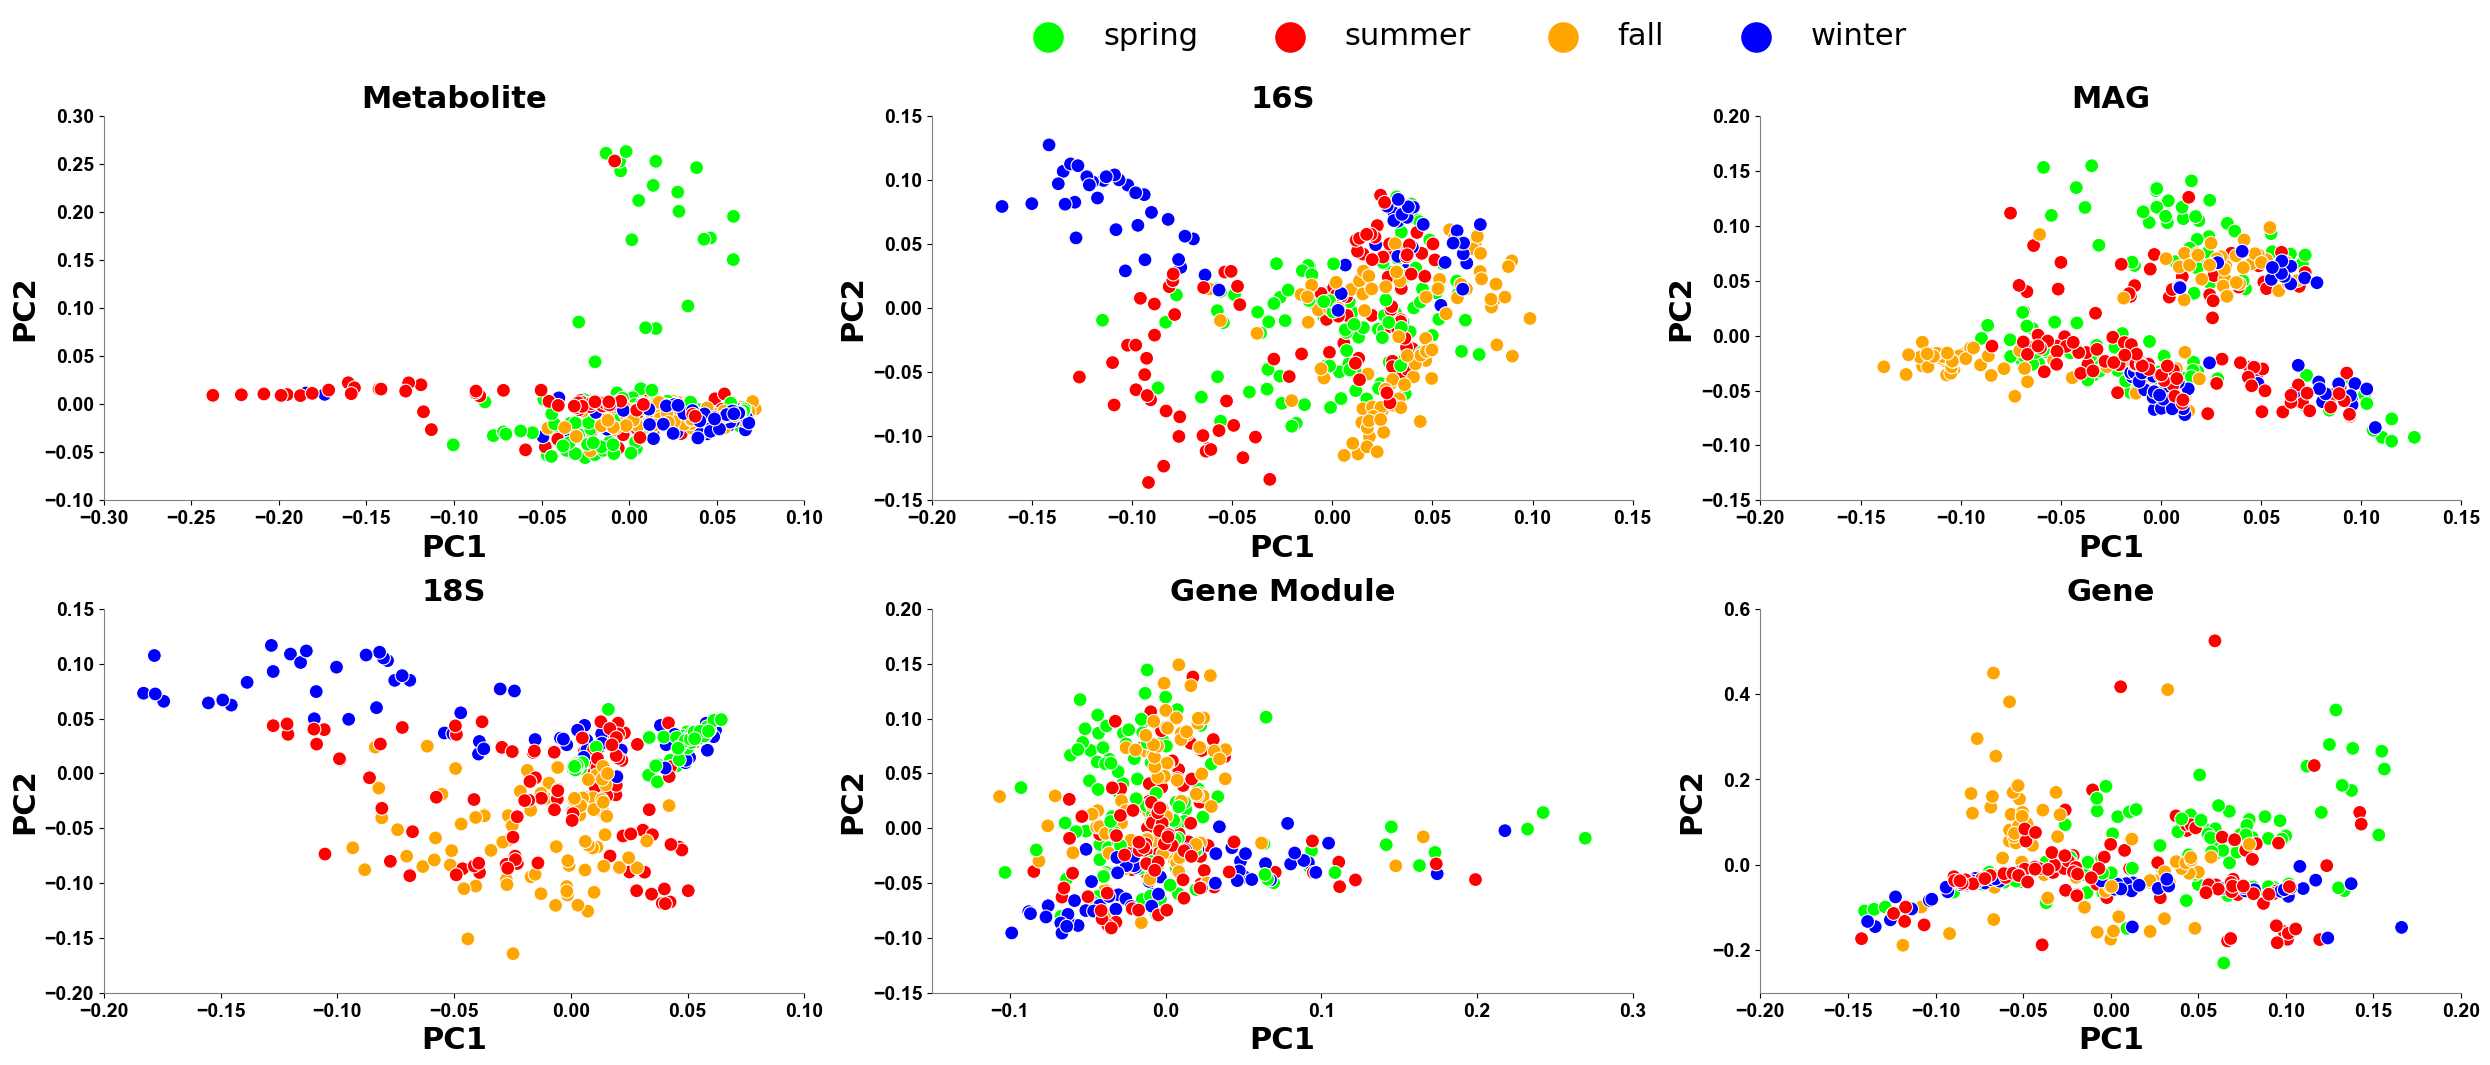

In [10]:
ordination_scatterplots(rpca_independent, metadata, 
                        hue="season", hue_order=['spring', 'summer', 'fall','winter'], 
                        x="PC1", y="PC2", palette=["#00FF00","#FF0000","#FFA500", "#0000FF"], 
                        subplots=(2,3), save_fig=True, figsize=(25, 10),
                        save_path='../results/joint-rpca/figures/rpca-ord-season-scatter.pdf')

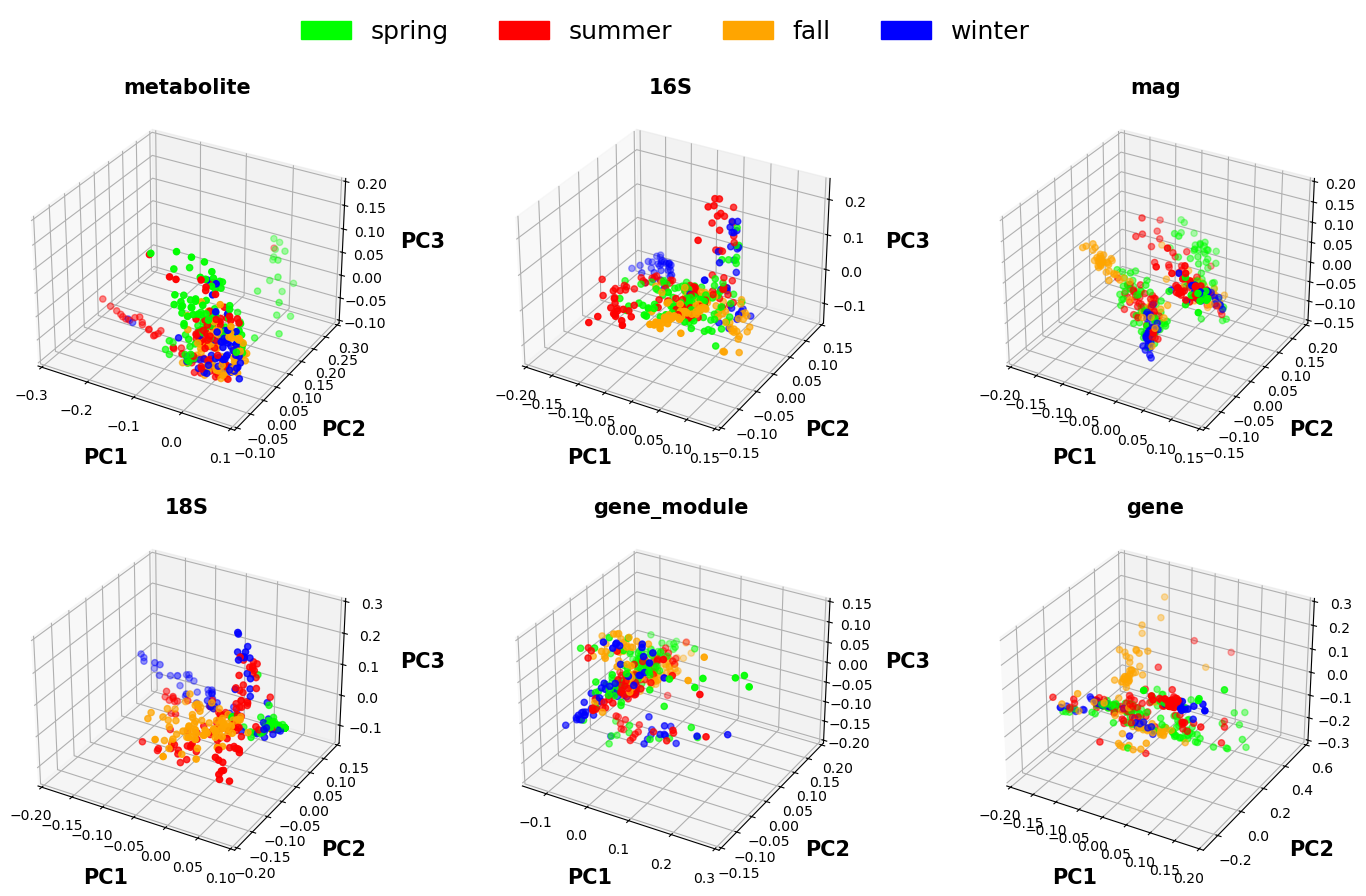

In [11]:
ord_scatter_3D(rpca_independent, metadata, 
               hue="season", hue_order=['spring', 'summer', 'fall','winter'], 
               pcs=["PC1","PC2","PC3"], palette=["#00FF00","#FF0000","#FFA500", "#0000FF"], 
               subplots=(2,3), figsize=(25, 10))

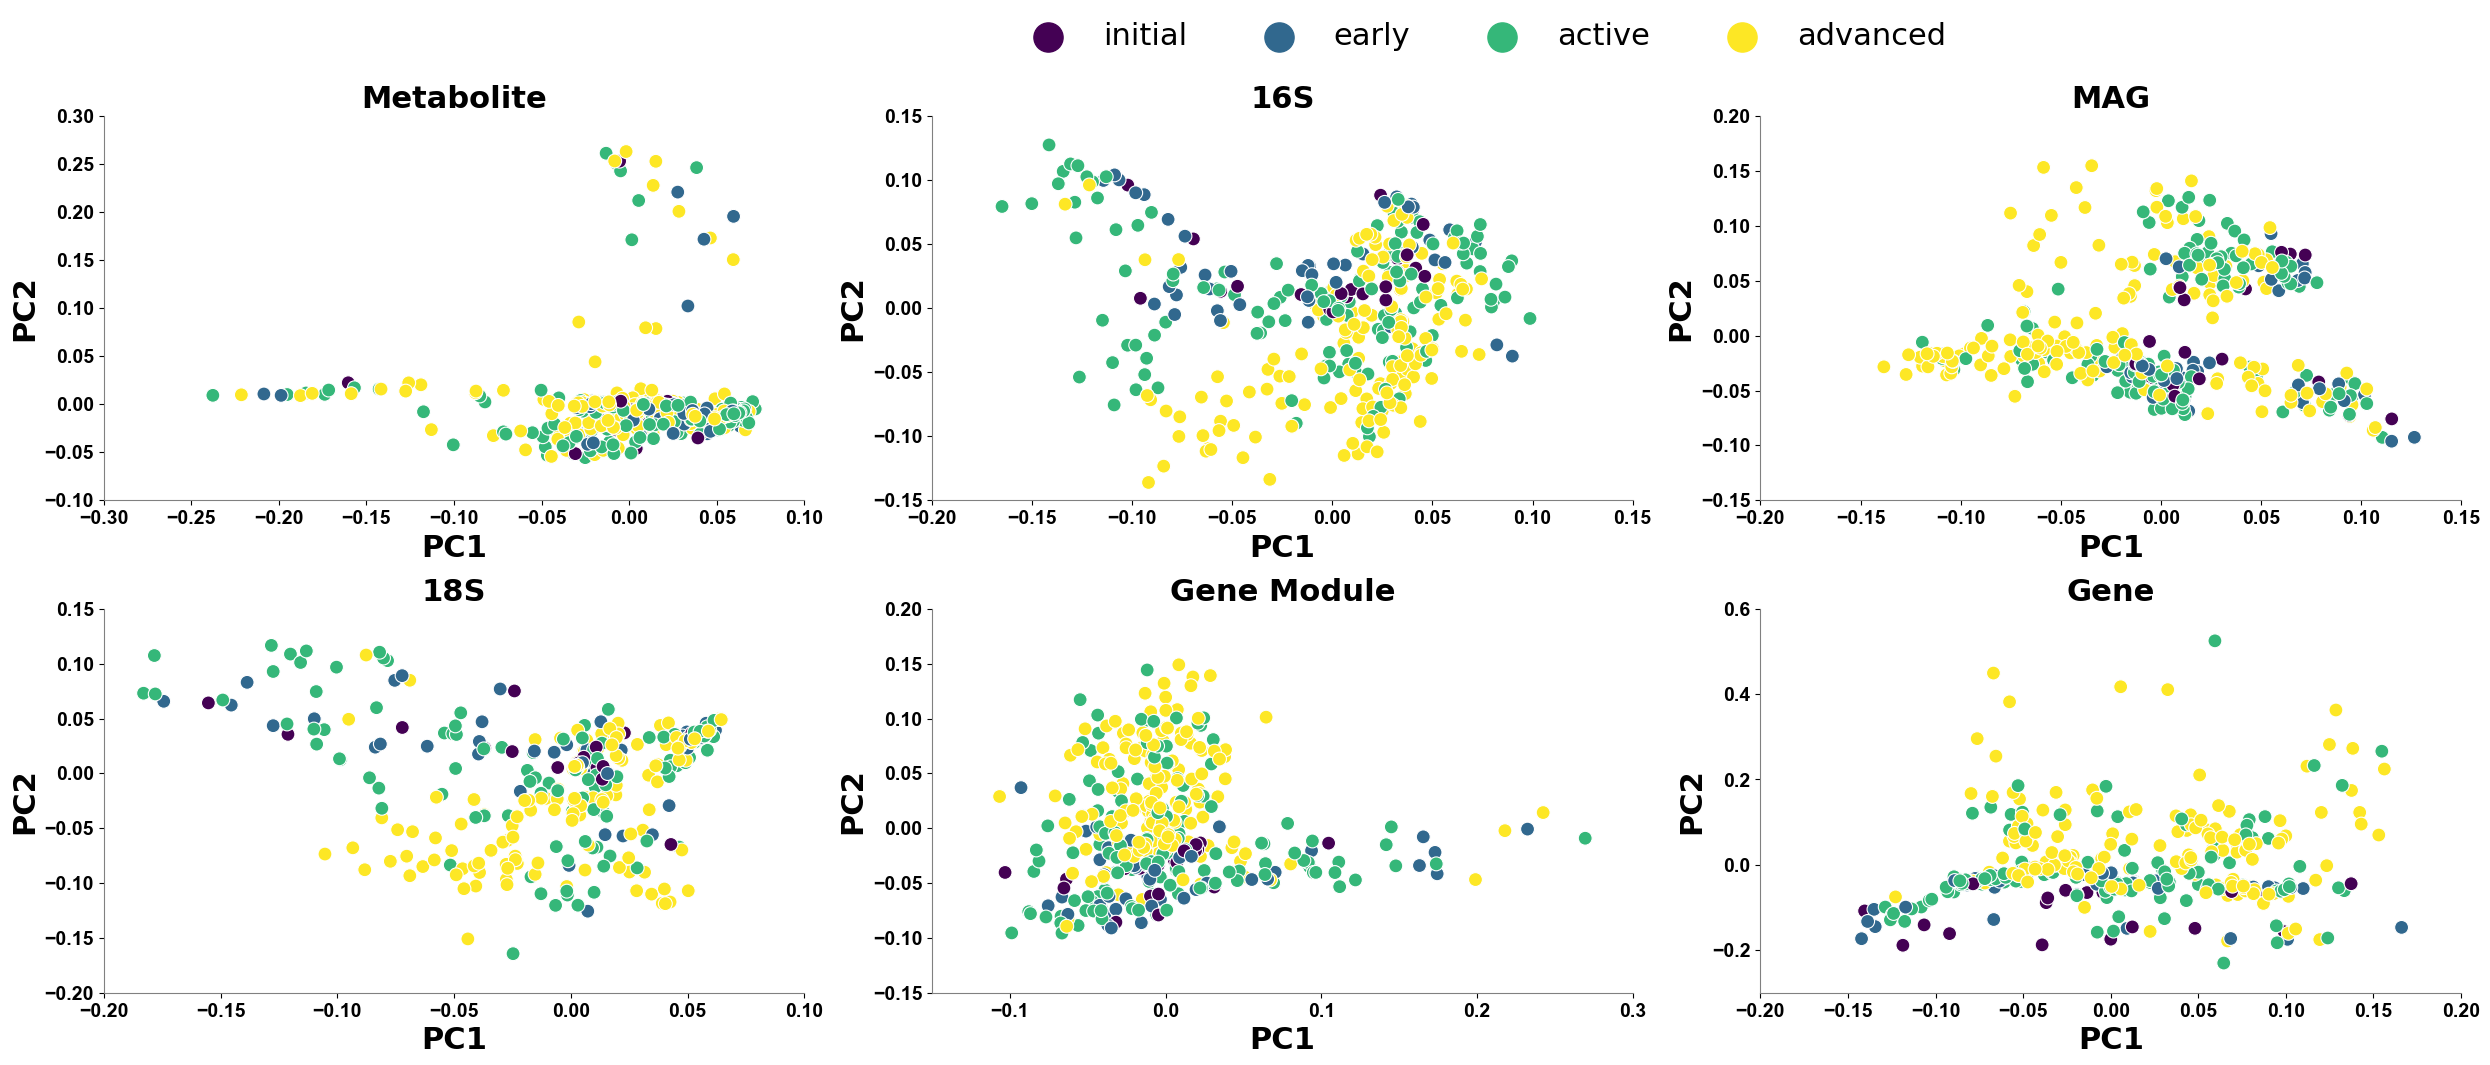

In [12]:
ordination_scatterplots(rpca_independent, metadata, 
                        hue="add_0c_group", hue_order=['initial', 'early', 'active', 'advanced'], 
                        x="PC1", y="PC2", palette=["#440154FF","#31688EFF","#35B779FF","#FDE725FF"], 
                        subplots=(2,3), save_fig=True, figsize=(25, 10),
                        save_path='../results/joint-rpca/figures/rpca-ord-add-scatter.pdf')

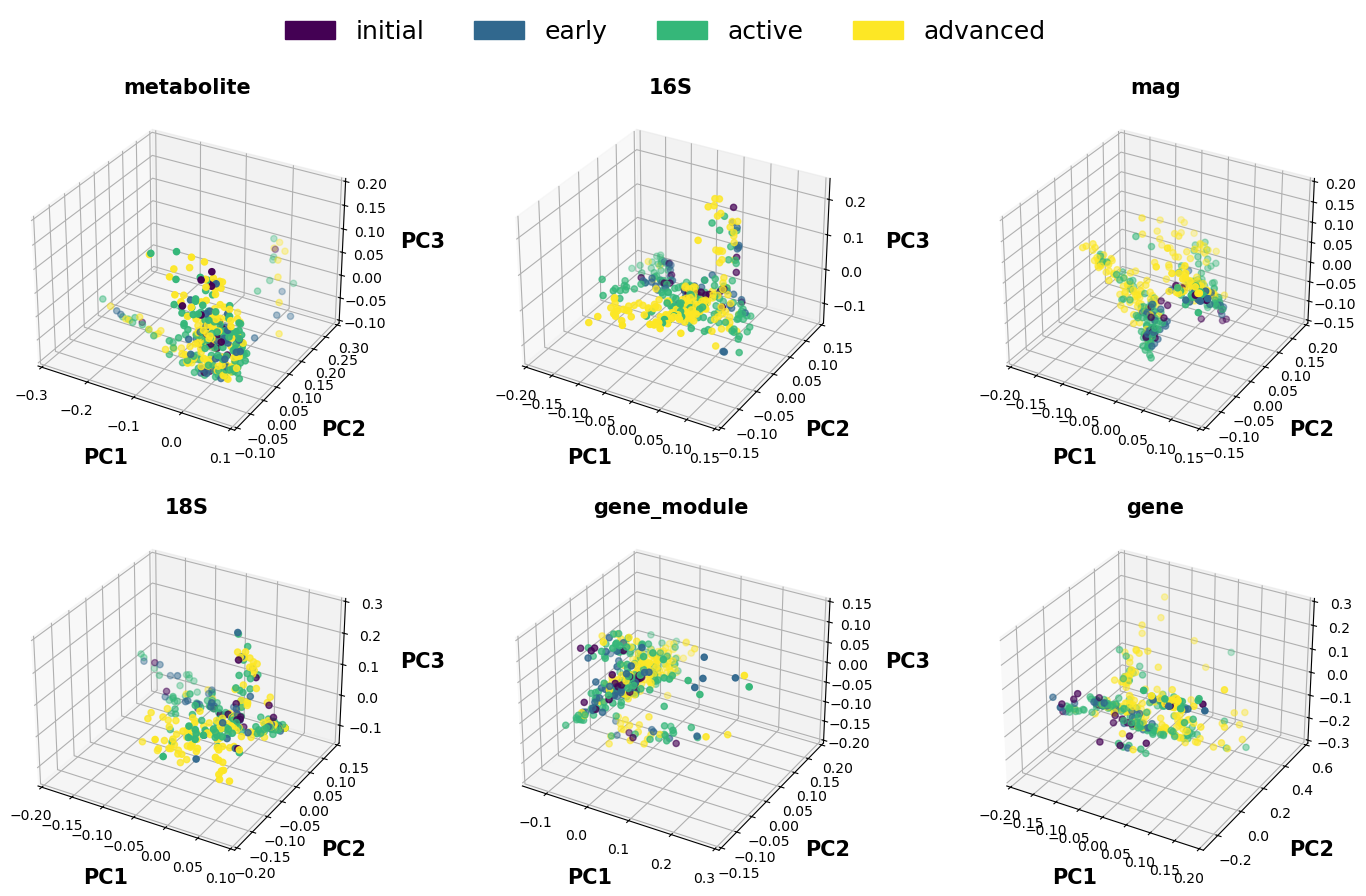

In [14]:
ord_scatter_3D(rpca_independent, metadata, 
               hue="add_0c_group", hue_order=['initial', 'early', 'active', 'advanced'], 
               pcs=["PC1","PC2","PC3"], palette=["#440154FF","#31688EFF","#35B779FF","#FDE725FF"], 
               subplots=(2,3), figsize=(25, 10))

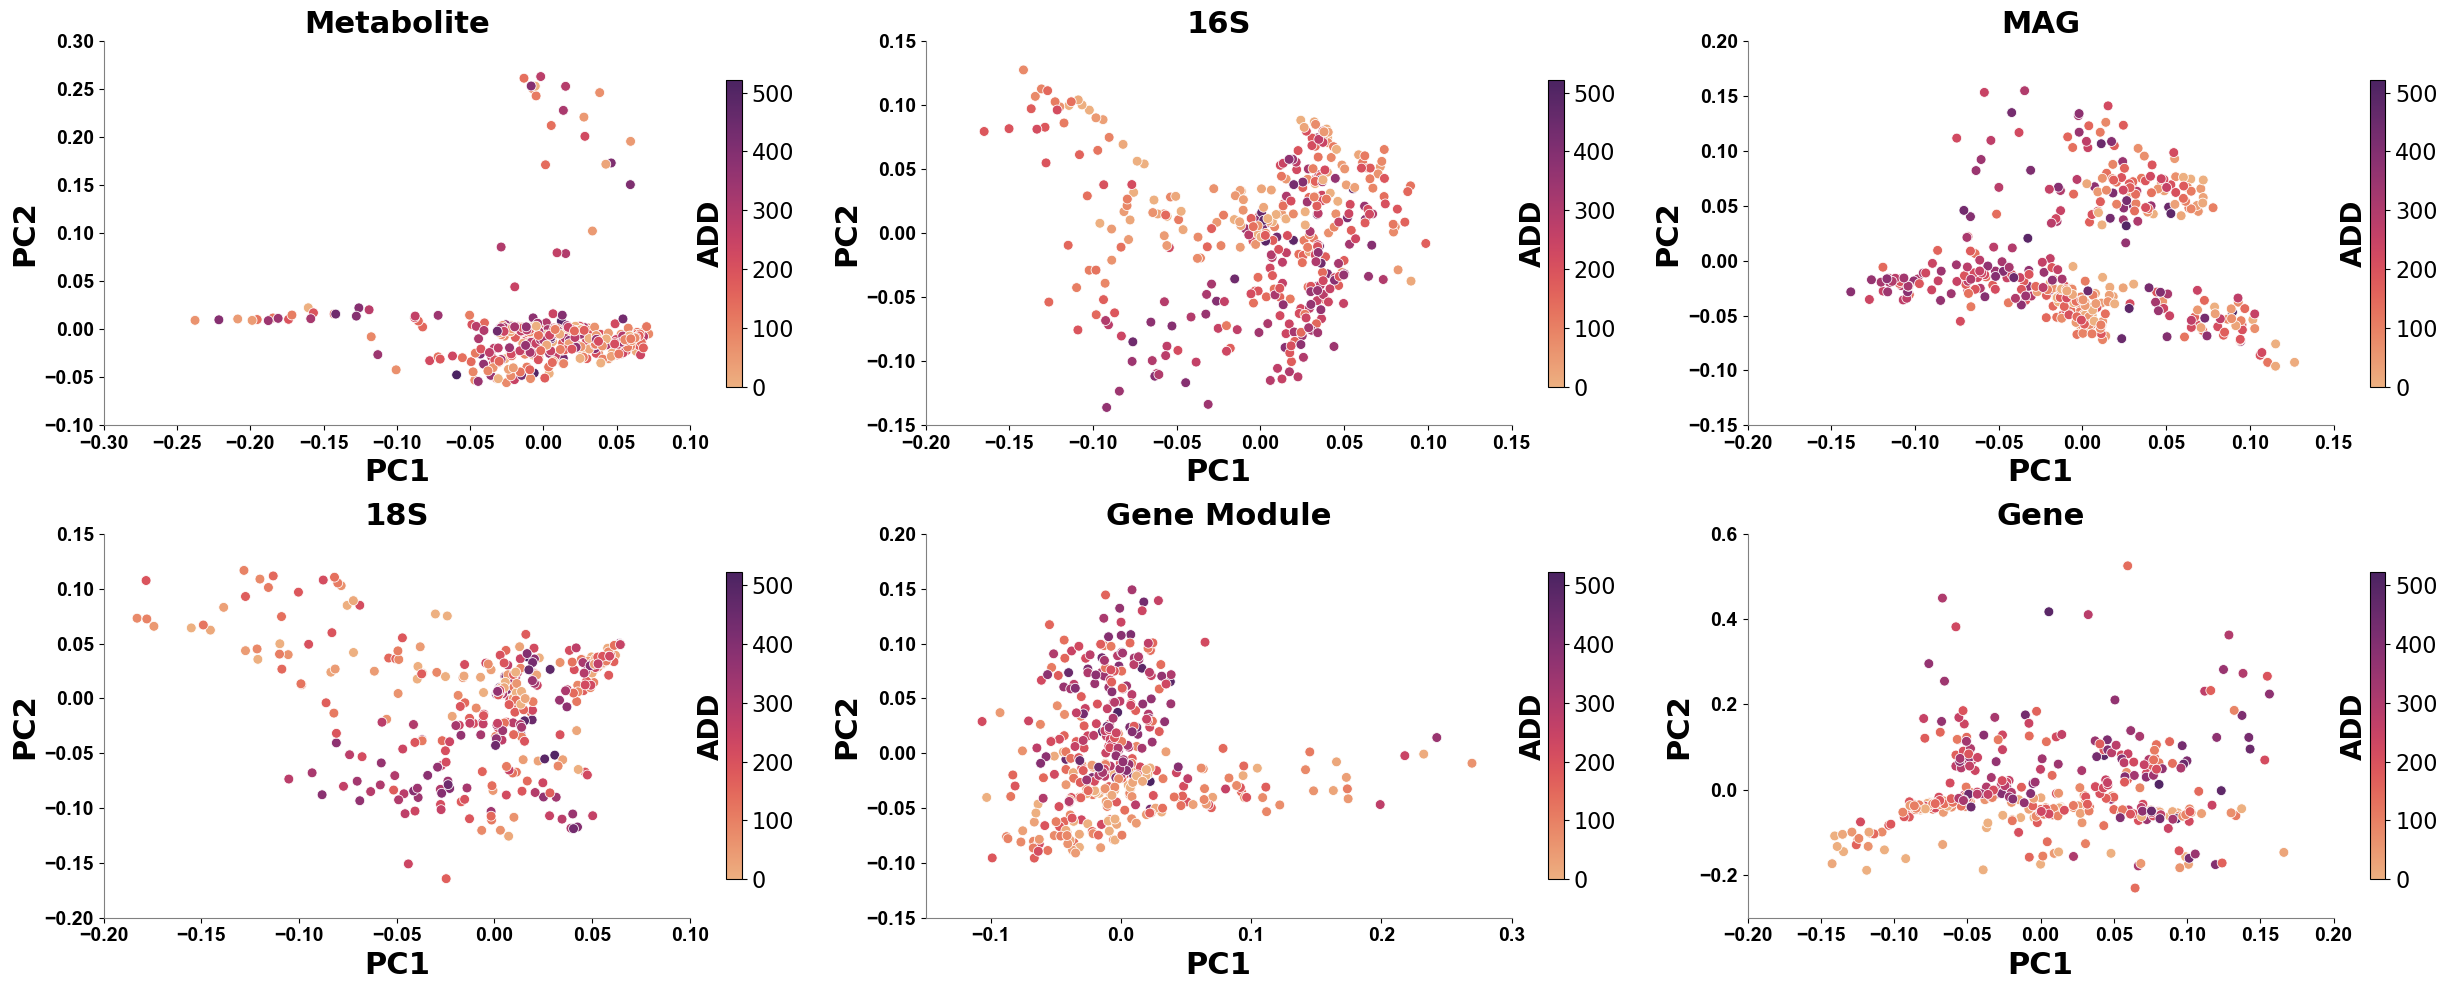

In [14]:
ordination_scatterplots(rpca_independent, metadata, 
                        hue="add_0c", hue_order=None, cbar_label='ADD',
                        x="PC1", y="PC2", colorbar=True, point_size=50,
                        palette=sns.color_palette("flare", as_cmap=True),
                        subplots=(2,3), save_fig=True, figsize=(25, 10),
                        save_path='../results/joint-rpca/figures/rpca-ord-add-cont-scatter.pdf')

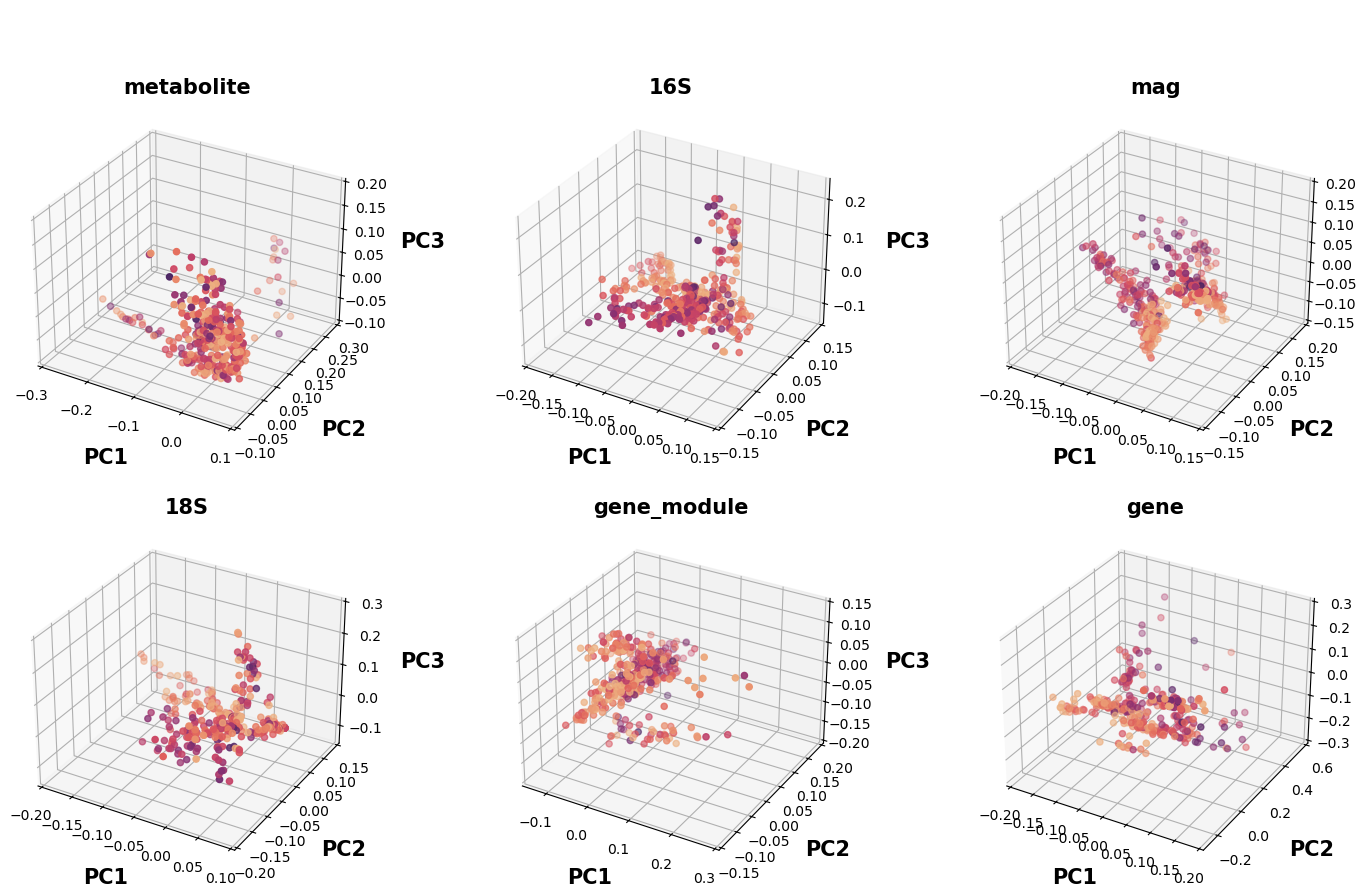

In [16]:
ord_scatter_3D(rpca_independent, metadata, 
               hue="add_0c", hue_order=None, 
               pcs=["PC1","PC2","PC3"], 
               palette=sns.color_palette("flare", as_cmap=True), 
               subplots=(2,3), figsize=(25, 10))

### Kruskal Wallis

In [15]:
n_PCS = 3

In [16]:
cats_of_interest = ['facility', 'season', 'add_0c_group']
kw_df_all = []

for cat_of_interest in cats_of_interest:
    kw_df_cat = pd.DataFrame()

    for tblid, (ord_, _, _) in rpca_independent.items():    
        ord_samples = ord_.samples.rename(columns={0:"PC1", 1:"PC2", 
                                                   2:"PC3", 3:"PC4"})
        ord_plt = pd.concat([ord_samples, metadata], axis=1, sort=True)
        #drop rows with nan values
        ord_plt = ord_plt.dropna()
        #print(tblid)
        #display(ord_plt.head())
        kw_h = []
        kw_p = []

        df_index = []
        for i in range(n_PCS):
            grouped = ord_plt.groupby(cat_of_interest)["PC%i" % (i+1)]
            groups = [group for _, group in grouped]
            # Perform the Kruskal-Wallis test
            h, p = kruskal(*groups)
            kw_h.append(h)
            kw_p.append(p)
            df_index.append("{}_PC{}".format(tblid, i+1))

        kw_df_i = pd.DataFrame(list(zip(kw_h, kw_p)), columns=['H-statistic', 'p-value'], 
                                index=df_index)
        kw_df_cat = pd.concat([kw_df_cat, kw_df_i])

    kw_df_all.append(kw_df_cat)
kw_df_all = pd.concat(kw_df_all, axis=1, keys=cats_of_interest)

In [18]:
#save results
kw_df_all.to_csv('../results/joint-rpca/Tables/individual_rpca_kw.csv')
kw_df_all

facility                    season                \
                 H-statistic       p-value H-statistic       p-value   
metabolite_PC1     15.581948  4.134499e-04   72.802380  1.071578e-15   
metabolite_PC2     26.909432  1.434468e-06   20.862341  1.124383e-04   
metabolite_PC3     14.244524  8.069395e-04   56.185442  3.835053e-12   
16S_PC1           162.725928  4.618635e-36   45.709887  6.536971e-10   
16S_PC2            81.750833  1.770240e-18  113.979531  1.526772e-24   
16S_PC3           138.333824  9.145170e-31   38.418103  2.305239e-08   
mag_PC1           219.418480  2.258824e-48   30.852523  9.130475e-07   
mag_PC2           274.409683  2.586393e-60   44.087142  1.446207e-09   
mag_PC3           126.523778  3.355141e-28   21.859008  6.978906e-05   
18S_PC1            91.983107  1.061994e-20  138.466259  8.093738e-30   
18S_PC2            29.171047  4.630071e-07  200.545606  3.215668e-43   
18S_PC3            71.247557  3.379010e-16   60.482818  4.635422e-13   
gene_module_PC1    26.666131  1.620031e-06    4.905711  1.788331e-01   
gene_module_PC2    30.951118  1.901298e-07   87.573699  7.271376e-19   
gene_module_PC3   186.501340  3.175035e-41   19.322564  2.344640e-04   
gene_PC1          262.262143  1.123309e-57   24.510005  1.954678e-05   
gene_PC2           67.237293  2.509616e-15   48.717287  1.498346e-10   
gene_PC3          212.602075  6.824111e-47   37.616614  3.407239e-08   
metabolomics_PC1   15.581948  4.134499e-04   72.802380  1.071578e-15   
metabolomics_PC2   26.909432  1.434468e-06   20.862341  1.124383e-04   
metabolomics_PC3   14.244524  8.069395e-04   56.185442  3.835053e-12   

                 add_0c_group                
                  H-statistic       p-value  
metabolite_PC1      11.382883  9.825812e-03  
metabolite_PC2       5.808234  1.213221e-01  
metabolite_PC3       3.135028  3.712715e-01  
16S_PC1              6.824725  7.769924e-02  
16S_PC2             61.835421  2.382474e-13  
16S_PC3             37.798484  3.118213e-08  
mag_PC1             41.911506  4.189415e-09  
mag_PC2             17.860424  4.699862e-04  
mag_PC3             64.774044  5.606498e-14  
18S_PC1              0.371468  9.460715e-01  
18S_PC2             31.494116  6.689292e-07  
18S_PC3              2.617841  4.543704e-01  
gene_module_PC1      0.333920  9.535277e-01  
gene_module_PC2     97.900436  4.394332e-21  
gene_module_PC3      7.863320  4.892257e-02  
gene_PC1            20.595775  1.277153e-04  
gene_PC2            92.562063  6.168479e-20  
gene_PC3             3.836852  2.796286e-01  
metabolomics_PC1    11.382883  9.825812e-03  
metabolomics_PC2     5.808234  1.213221e-01  
metabolomics_PC3     3.135028  3.712715e-01

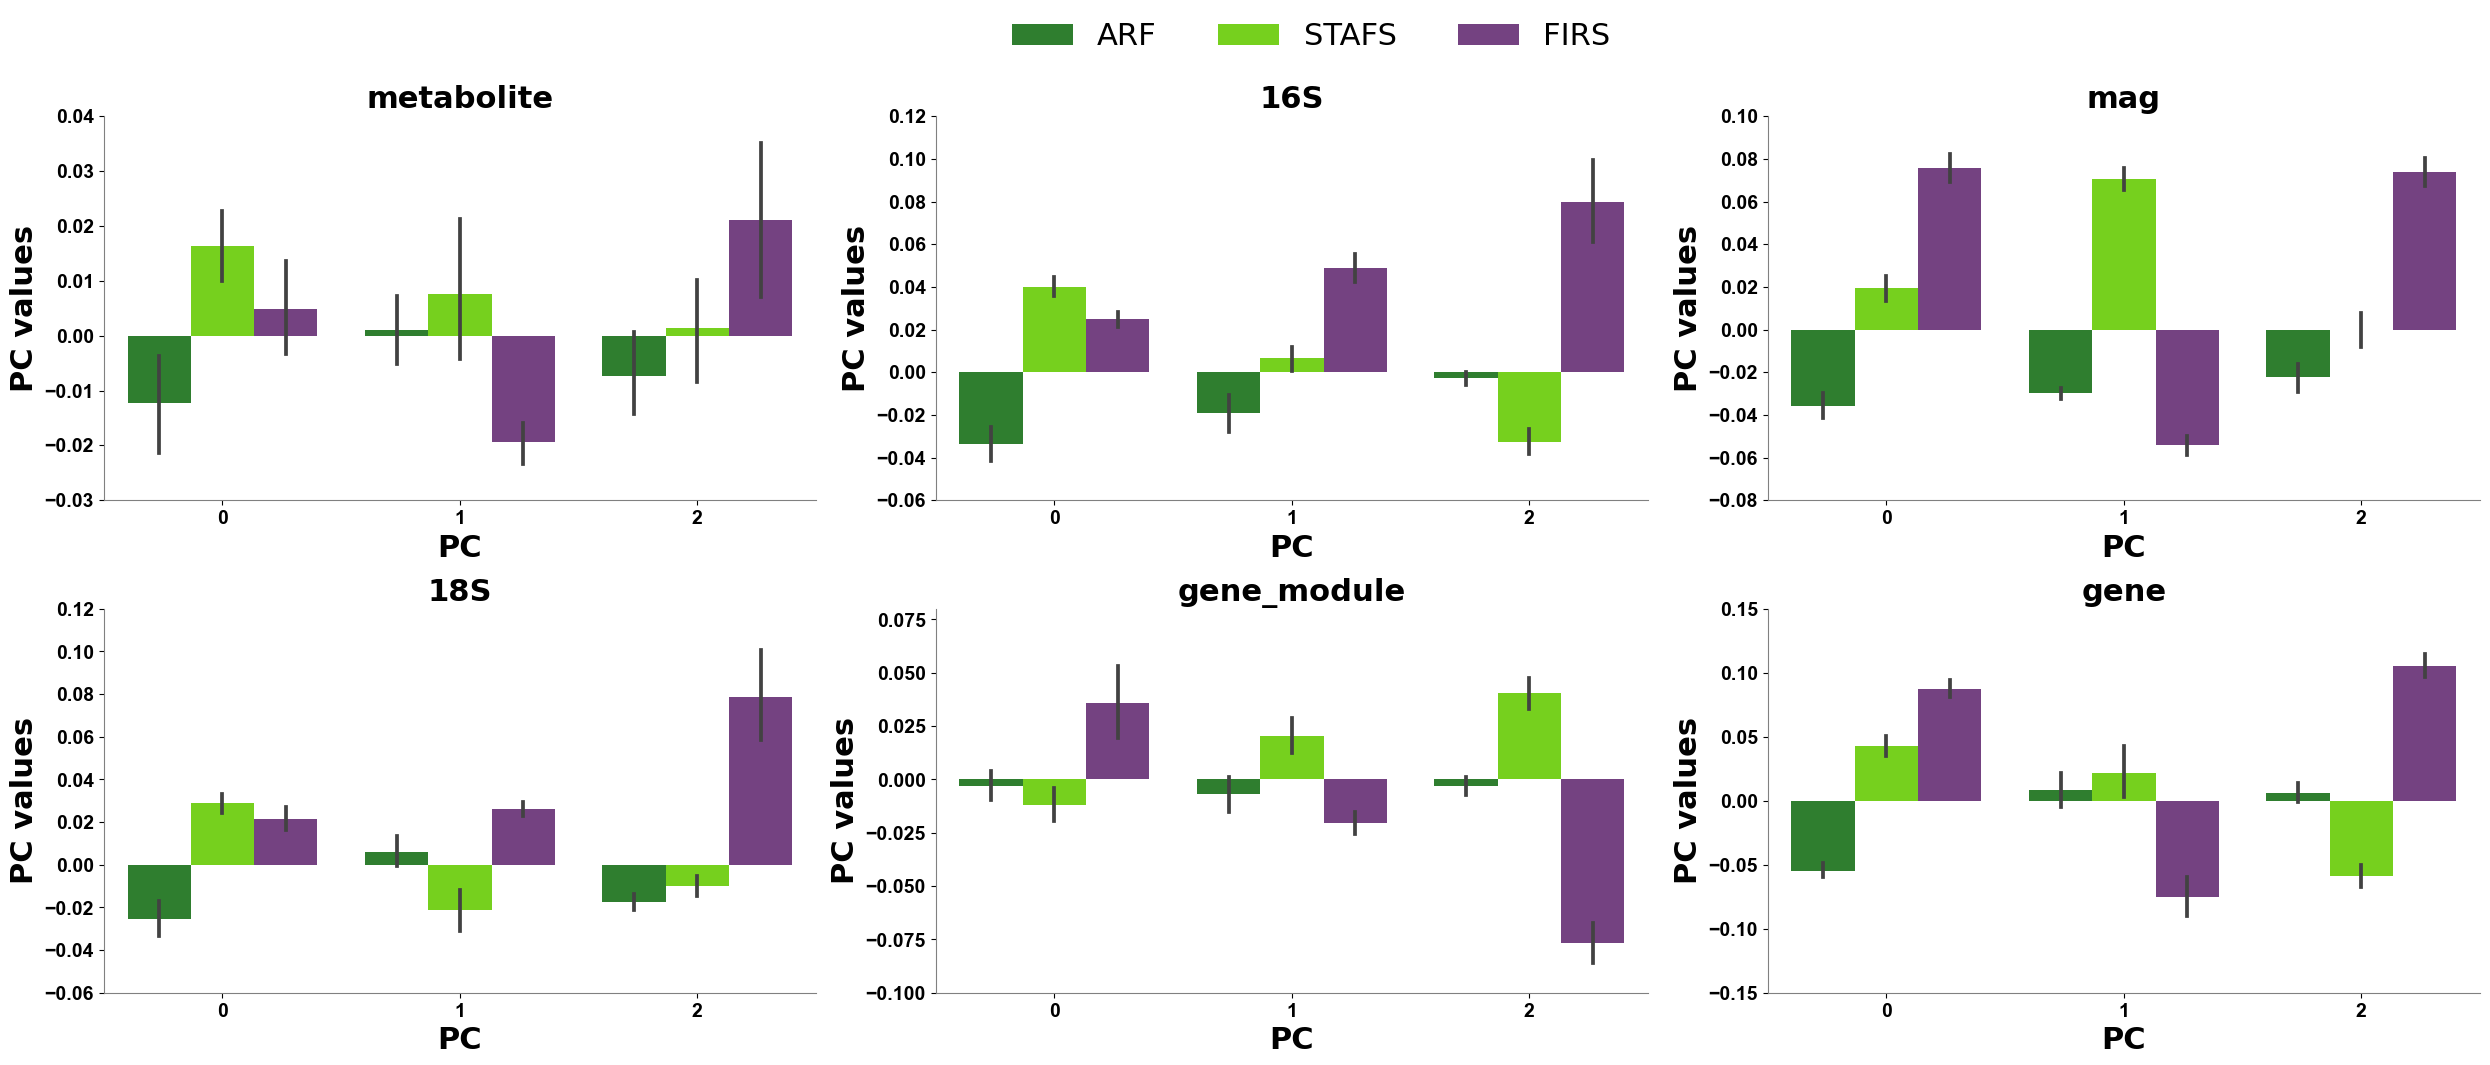

In [19]:
palette=["#228b22","#76ee00","#7a378b"]
fig, axn = plt.subplots(2, 3, figsize=(25, 10))
axn = axn.flatten()

for ax, (tblid, (ord_, dist_, _)) in zip(axn, rpca_independent.items()):
    
    ord_plt = ord_.samples
    ord_plt = pd.concat({c:pd.concat([ord_plt[[c]].rename({c:'PC'}, axis=1), metadata], axis=1, sort=True).reset_index()
                         for c in ord_plt.columns}, axis=0).reset_index()
    sns.barplot(x='level_0', y='PC', hue='facility', hue_order = ['ARF', 'STAFS', 'FIRS'], data=ord_plt, ax=ax, palette=palette)
    
    ax.set_xlabel('PC',
                  color='black',
                  weight='bold',
                  fontsize=22)
    ax.set_ylabel('PC values',
                  color='black',
                  weight='bold',
                  fontsize=22)

    ax.set_title(tblid,
                  color='black',
                  weight='bold',
                  fontsize=22)

    # fix backround
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')

    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(14)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(14)
    ax.legend_.remove()
    
plt.tight_layout()

legend = ax.legend(loc=2, 
           bbox_to_anchor=(-1.1, 2.6),
           prop={'size':22},
           title="",
           fancybox=True,
                    framealpha=.0,
           ncol=3, markerscale=3.5)
legend.get_title().set_fontsize('16')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)

plt.show()

In [20]:
def rpca_feat_trajectory(tables, rpca_results,
                         metadata, pc_dict):

    features_used_all = {}
    lr_cols = []
    metadata_logratios = metadata.copy()

    for modality, (ord_, _, _) in rpca_results.items():
        if modality == "16S":
            continue
        elif modality == "gene":
            continue

        print(modality)
        ids_to_keep = metadata_logratios.index
        table_ = tables[modality].filter(ids_to_keep, axis='sample')
        table_ = tables[modality].to_dataframe()
        pc_ = pc_dict[modality]
        feats_ = ord_.features[[pc_]].sort_values(ascending=False, by=pc_)

        for i_ in range(1, 1500):
            num = feats_.iloc[:i_, :].index
            den = feats_.iloc[-i_:, :].index
            features_used_all[modality] = [num[:19], den[:19]]
            lr_ = np.log(table_.loc[num, :].sum(0)) - np.log(table_.loc[den, :].sum(0))
            
            if (sum(np.isfinite(lr_)) / table_.shape[1]) >= 0.99:
                break
        
        print(i_)
        print(sum(np.isfinite(lr_)) / table_.shape[1])
        lr_ = lr_.sparse.to_dense()
        lr_[~np.isfinite(lr_)] = np.nan
        metadata_logratios[modality + '_logratio'] = lr_
        lr_cols.append(modality + '_logratio')

    return metadata_logratios, features_used_all

In [21]:
#rpca_independent['metabolite'] #(ord_, dist_, reconstruction_error)
#rpca_independent, metadata, tables

metab_ids = pd.read_excel('../network/metabolite_formulas.xlsx', index_col=0)
metab_ids.index = ['metab_' + str(x) for x in metab_ids.index]
metab_ids_class = metab_ids.dropna(subset=['most specific class'])

bt_tmp, df_tmp = tables['metabolite'], tables['metabolite'].to_dataframe()
ord_tmp = rpca_independent['metabolite'][0].features
keep_metab = set(metab_ids_class.index) & set(bt_tmp.ids('observation'))
bt_tmp = bt_tmp.filter(keep_metab, axis='observation')
df_tmp = df_tmp.loc[list(keep_metab), :]
ord_tmp = ord_tmp.loc[list(keep_metab), :]

#update
tables['metabolite'] = bt_tmp
rpca_independent['metabolite'][0].features = ord_tmp

In [22]:
#update col names in ordination results
for (tblid, (ord_, _, _)) in rpca_independent.items():
    print(tblid)
    #prepare dataframe
    ord_samples = ord_.samples.rename(columns={0:'PC1', 1:'PC2', 
                                               2:'PC3', 3:'PC4'})
    ord_features = ord_.features.rename(columns={0:'PC1', 1:'PC2', 
                                                 2:'PC3', 3:'PC4'})
    rpca_independent[tblid][0].samples = ord_samples
    rpca_independent[tblid][0].features = ord_features

metabolite
16S
mag
18S
gene_module
gene
metabolomics


In [23]:
rpca_independent_sub = rpca_independent.copy()
del rpca_independent_sub['metabolomics']

rpca_independent_sub.keys()

dict_keys(['metabolite', '16S', 'mag', '18S', 'gene_module', 'gene'])

In [24]:
#feature trajectories informed by ordination results
omic_pc = {'metabolite': 'PC2', '16S': 'PC2', 'mag': 'PC3',
            '18S': 'PC3', 'gene_module': 'PC2', 'gene': 'PC2',
            'metabolomics': 'PC2'}

metadata_logratios, features_used = rpca_feat_trajectory(tables, rpca_independent_sub, 
                                                         metadata, omic_pc)

metabolite
71
0.9973262032085561
mag
14
0.9919786096256684
18S
1499
0.8636363636363636
gene_module
4
0.9946524064171123


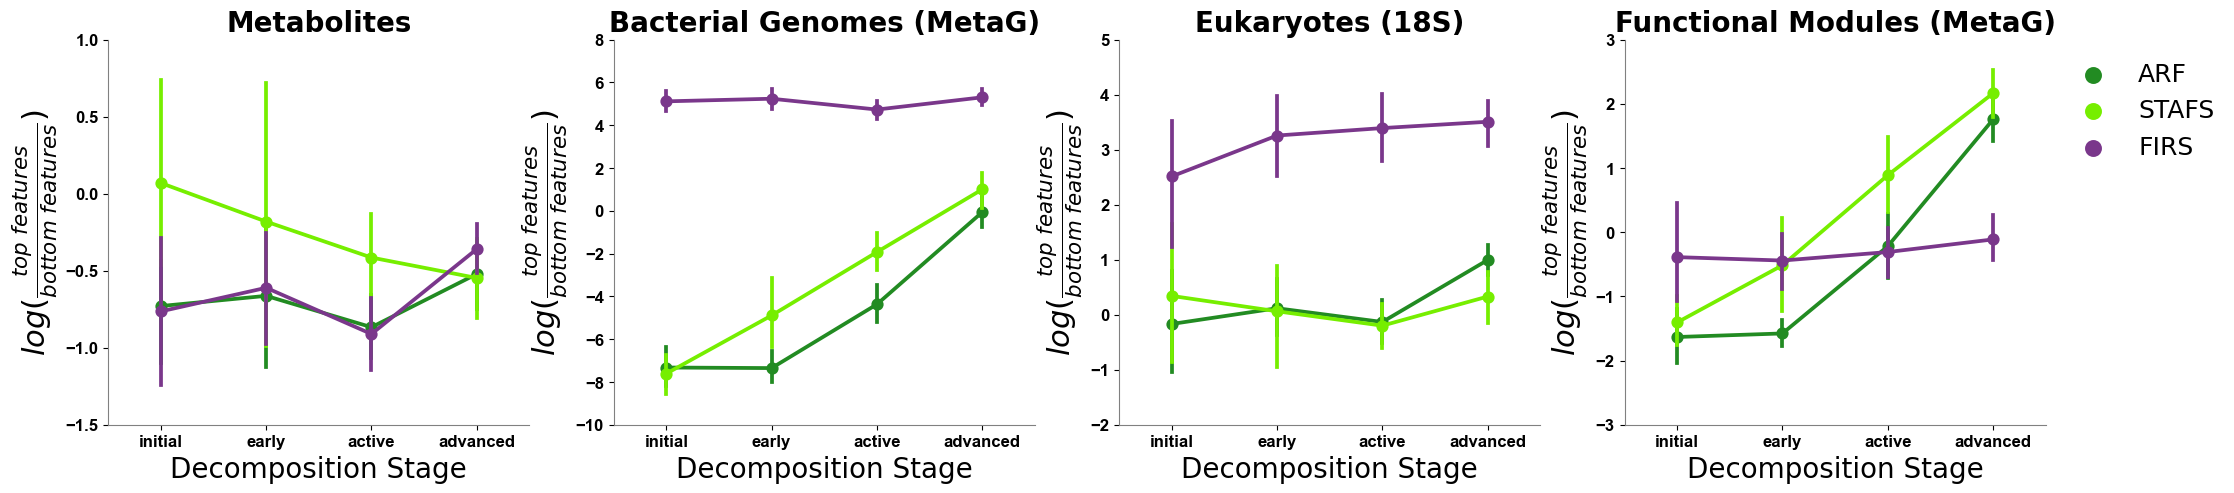

In [29]:
fig, axn = plt.subplots(1, 4, figsize=(5*5, 5))

titles_ =  {'mag_logratio':'Bacterial Genomes (MetaG)',
            '18S_logratio':'Eukaryotes (18S)',
            'gene_module_logratio':'Functional Modules (MetaG)',
            'metabolite_logratio':'Metabolites'}

lr_cols = ['metabolite_logratio', 'mag_logratio', 
           '18S_logratio', 'gene_module_logratio']

palette=["#228b22","#76ee00","#7a378b"]

for ax, lr_ in zip(axn, lr_cols):

    #metadata_logratios[lr_] = -1*metadata_logratios[lr_]
    sns.pointplot(x='add_0c_group', y=lr_, hue='facility', 
                  hue_order = ['ARF', 'STAFS', 'FIRS'], palette=palette,
                  order = ['initial', 'early', 'active', 'advanced'],
                  data=metadata_logratios, ax=ax)
    ax.set_xlabel('Decomposition Stage', color='black', fontsize=20)
    ax.set_ylabel('$log(\\frac{top\,\,features}{bottom\,\,features})$',
                  color='black', weight='bold', fontsize=22)
    ax.set_title(titles_[lr_], color='black', weight='bold', fontsize=20)

    # fix backround
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')
    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(12)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(12)
    ax.legend_.remove()

legend = ax.legend(loc=2, bbox_to_anchor=(1, 1), prop={'size':18}, title="",
                   fancybox=True, framealpha=.0, ncol=1, markerscale=1.5)
legend.get_title().set_fontsize('16')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
plt.savefig('../results/joint-rpca/Figures/rpca-log-ratios.pdf',
           dpi=600, 
           bbox_inches='tight',
           edgecolor='none')
plt.show()

# joint-rpca

In [9]:
# # ONLY RUN ON FIRST ITERATION
# n_PCS = 4
# cv_all_joint = {}
# fold = 0
# ord_jnt, dist_jnt, cv_jnt = joint_rpca([v for k, v in tables_filtered.items()
#                                         if k in ['mag', '18S', 'gene_module', 'gene', 'metabolite']],
#                                         n_components=n_PCS,
#                                         max_iterations=15,
#                                         min_feature_count=10,
#                                         sample_metadata=metadata,
#                                         train_test_column='traintest_%i' % fold)
# cv_all_joint[0] = cv_jnt
# joint_rpca_results = {'joint': (ord_jnt, None, None)}

# # check CV error
# cv_all_joint_df = pd.concat(cv_all_joint).reset_index().rename({'level_0':'fold'}, axis=1)
# for f, df_ in cv_all_joint_df.groupby('fold'):
#     plt.errorbar(df_.iteration, df_['mean_CV'], yerr=df_['std_CV'], label='fold %i' % (f + 1))
# plt.legend()
# plt.show()

In [12]:
# save results
# n_PCS = 4
# ord_jnt.write('../results/joint-rpca/Ordinations/joint_ord_{}PCs.txt'.format(n_PCS))
# dist_jnt.write('../results/joint-rpca/Ordinations/joint_dist_{}PCs.txt'.format(n_PCS))
# cv_jnt.to_csv('../results/joint-rpca/Ordinations/joint_cv_{}PCs.txt'.format(n_PCS))

# for filtered data
#ord_jnt.write('../results/joint-rpca/Ordinations/joint_ord_{}PCs_top_filtered.txt'.format(n_PCS))
#dist_jnt.write('../results/joint-rpca/Ordinations/joint_dist_{}PCs_top_filtered.txt'.format(n_PCS))
#cv_jnt.to_csv('../results/joint-rpca/Ordinations/joint_cv_{}PCs_top_filtered.txt'.format(n_PCS))

'../results/joint-rpca/Ordinations/joint_ord_4PCs_top_filtered.txt'

In [31]:
# load results form prior run
joint_rpca_results = {'joint': (OrdinationResults.read('../results/joint-rpca/Original/ord.txt'), None, None) }

### 2D and 3D Scatterplots

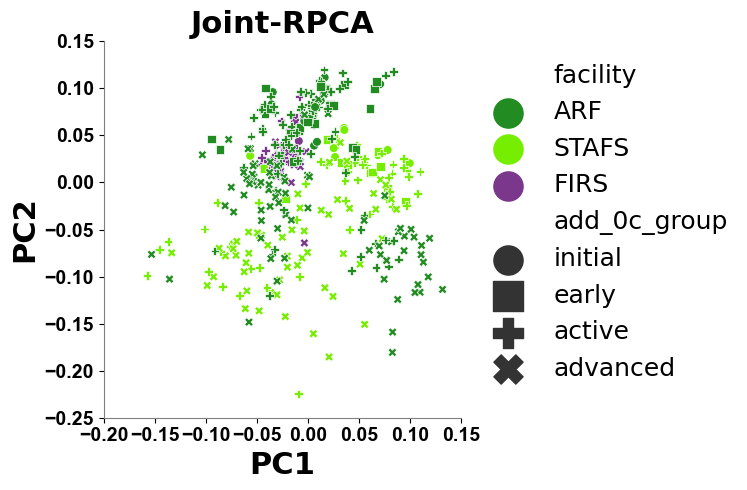

In [32]:
palette=["#228b22","#76ee00","#7a378b"]
markers = {"initial": "o", "early": "s", "active": "P", "advanced": "X"}

ordination_scatterplots(joint_rpca_results, metadata, x="PC1", y="PC2", 
                        hue="facility", hue_order=['ARF', 'STAFS', 'FIRS'], 
                        palette=palette, markers=markers, style='add_0c_group',
                        style_order=['initial', 'early', 'active', 'advanced'], 
                        point_size=40, subplots=None, figsize=(5, 5), save_fig=True, 
                        save_path='../results/joint-rpca/figures/joint-rpca-ord-facility-scatter.pdf')

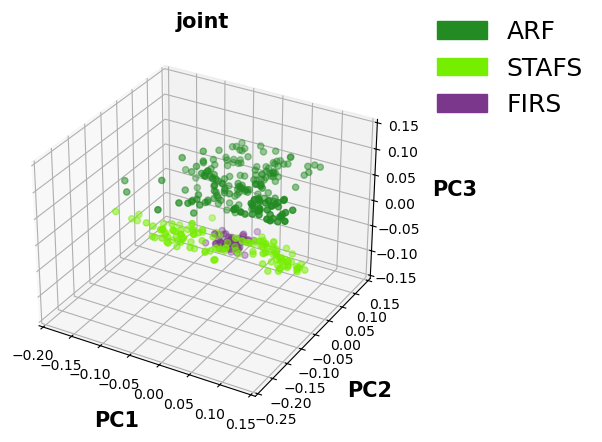

In [33]:
ord_scatter_3D(joint_rpca_results, metadata, 
               hue="facility", hue_order=['ARF', 'STAFS', 'FIRS'], 
               pcs=["PC1","PC2","PC3"], palette=["#228b22","#76ee00","#7a378b"], 
               subplots=None, figsize=(5, 5))

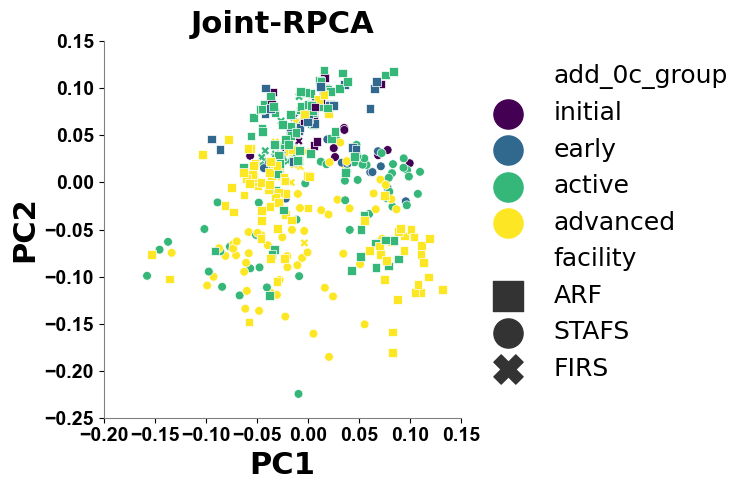

In [34]:
palette=["#440154FF","#31688EFF","#35B779FF","#FDE725FF"]
markers = {"ARF": "s", "STAFS": "o", "FIRS": "X"}

ordination_scatterplots(joint_rpca_results, metadata, x="PC1", y="PC2", 
                        hue="add_0c_group", hue_order=['initial', 'early', 'active', 'advanced'], 
                        palette=palette, markers=markers, 
                        style='facility', style_order=['ARF', 'STAFS', 'FIRS'], 
                        point_size=40, subplots=None, figsize=(5, 5), save_fig=True, 
                        save_path='../results/joint-rpca/figures/joint-rpca-ord-add1-scatter.pdf')

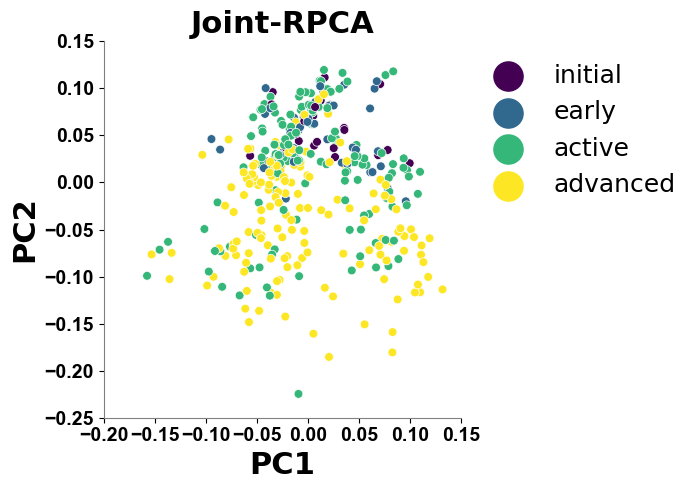

In [35]:
palette=["#440154FF","#31688EFF","#35B779FF","#FDE725FF"]
markers = {"ARF": "s", "STAFS": "o", "FIRS": "X"}

ordination_scatterplots(joint_rpca_results, metadata, x="PC1", y="PC2", 
                        hue="add_0c_group", hue_order=['initial', 'early', 'active', 'advanced'], 
                        palette=palette, markers=None, style=None, style_order=None, 
                        point_size=40, subplots=None, figsize=(5, 5), save_fig=True, 
                        save_path='../results/joint-rpca/figures/joint-rpca-ord-add2-scatter.pdf')

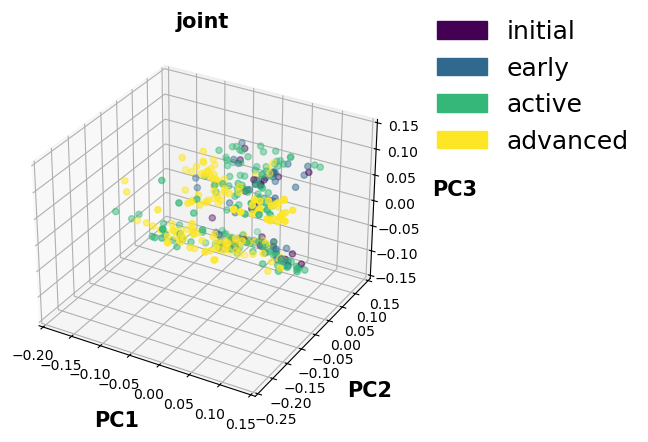

In [36]:
palette=["#440154FF","#31688EFF","#35B779FF","#FDE725FF"]

ord_scatter_3D(joint_rpca_results, metadata, 
               hue="add_0c_group", hue_order=['initial', 'early', 'active', 'advanced'], 
               pcs=["PC1","PC2","PC3"], palette=palette, 
               subplots=None, figsize=(5, 5))

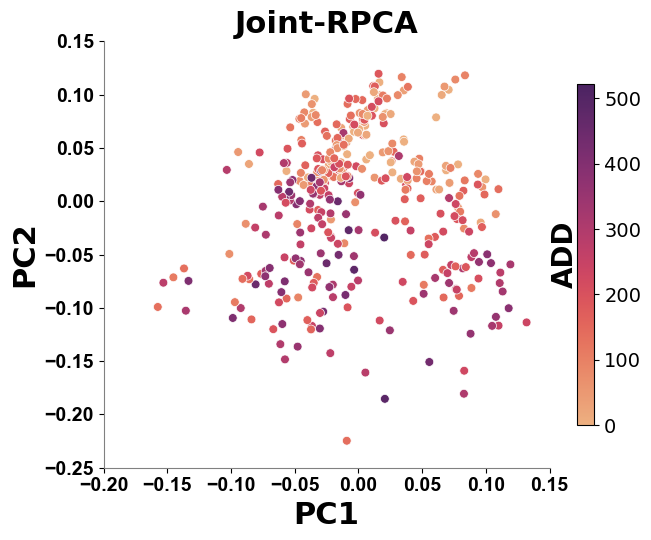

In [37]:
ordination_scatterplots(joint_rpca_results, metadata, x="PC1", y="PC2", 
                        hue="add_0c", hue_order=None, colorbar=True, cbar_label='ADD',
                        palette=sns.color_palette("flare", as_cmap=True),
                        markers=None, style=None, style_order=None, 
                        point_size=40, subplots=None, figsize=(7, 5.5), save_fig=True, 
                        save_path='../results/joint-rpca/figures/joint-rpca-ord-add3-scatter.pdf')

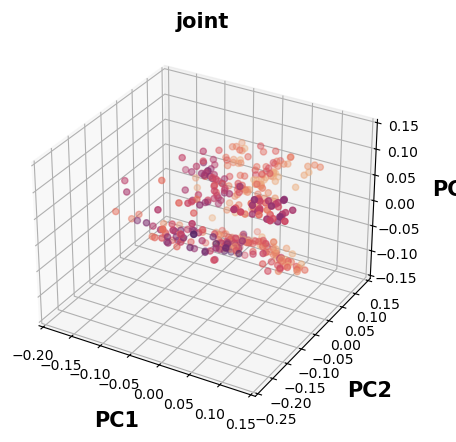

In [38]:
ord_scatter_3D(joint_rpca_results, metadata, 
               hue="add_0c", hue_order=None, 
               pcs=["PC1","PC2","PC3"], 
               palette=sns.color_palette("flare", as_cmap=True), 
               subplots=None, figsize=(5, 5))

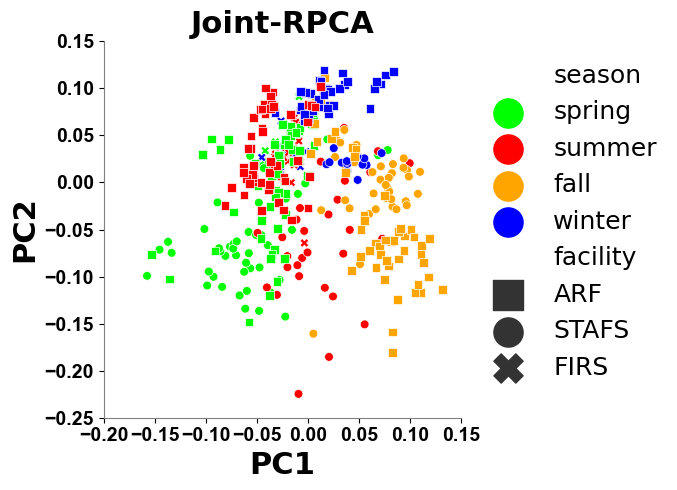

In [39]:
palette=["#00FF00","#FF0000","#FFA500", "#0000FF"]
markers = {"ARF": "s", "STAFS": "o", "FIRS": "X"}

ordination_scatterplots(joint_rpca_results, metadata, x="PC1", y="PC2", 
                        hue="season", hue_order=['spring', 'summer','fall','winter'], 
                        palette=palette, markers=markers, 
                        style='facility', style_order=['ARF', 'STAFS', 'FIRS'], 
                        point_size=40, subplots=None, figsize=(5, 5), save_fig=True, 
                        save_path='../results/joint-rpca/figures/joint-rpca-ord-season-scatter.pdf')

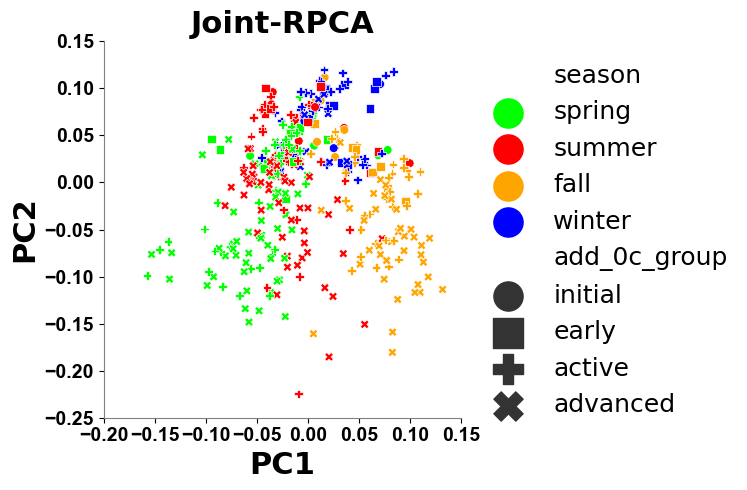

In [40]:
palette=["#00FF00","#FF0000","#FFA500", "#0000FF"]
markers = {"initial": "o", "early": "s", "active": "P", "advanced": "X"}

ordination_scatterplots(joint_rpca_results, metadata, x="PC1", y="PC2", 
                        hue="season", hue_order=['spring', 'summer','fall','winter'], 
                        palette=palette, markers=markers, 
                        style='add_0c_group', style_order=['initial', 'early', 'active','advanced'], 
                        point_size=40, subplots=None, figsize=(5, 5), save_fig=True, 
                        save_path='../results/joint-rpca/figures/joint-rpca-ord-season2-scatter.pdf')

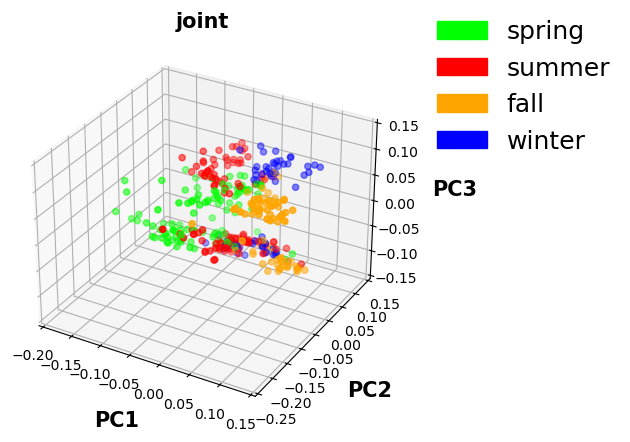

In [41]:
palette=["#00FF00","#FF0000","#FFA500", "#0000FF"]

ord_scatter_3D(joint_rpca_results, metadata, 
               hue="season", hue_order=['spring', 'summer','fall','winter'],  
               pcs=["PC1","PC2","PC3"], palette=palette, 
               subplots=None, figsize=(5, 5))

### Strip plots

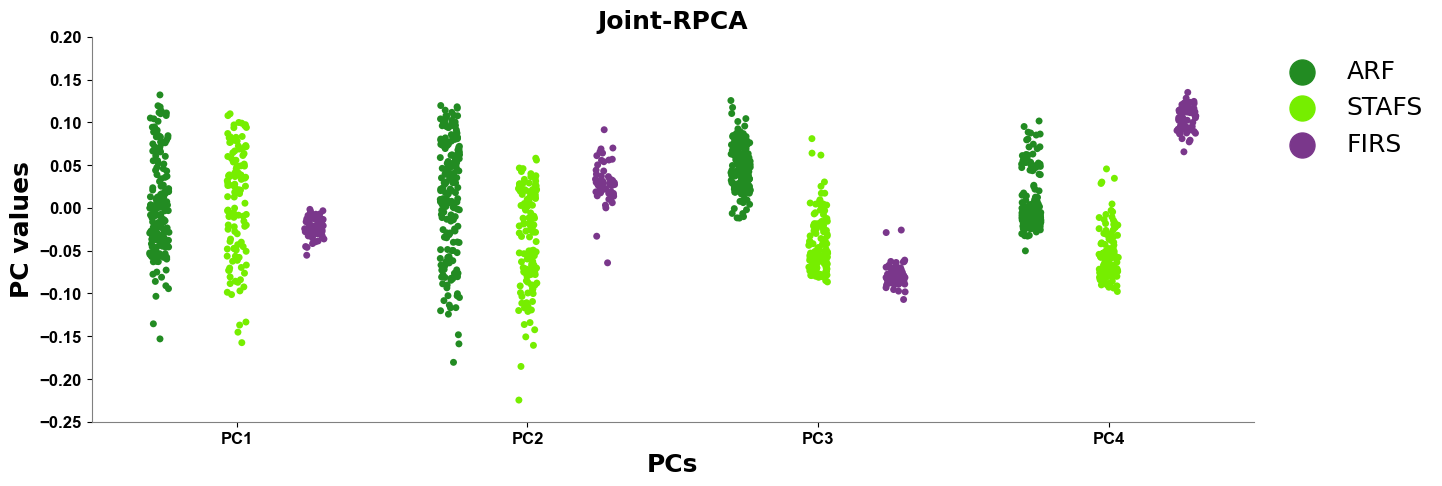

In [42]:
palette=["#228b22","#76ee00","#7a378b"]

fig, ax = plt.subplots(1,1, figsize=(15, 5))

ord_jnt = joint_rpca_results['joint'][0]
ord_plt = ord_jnt.samples.rename(columns={0:'PC1', 1:'PC2', 2:'PC3', 3:'PC4'})
ord_plt = pd.concat({c:pd.concat([ord_plt[[c]].rename({c:'PC'}, axis=1), metadata], axis=1, sort=True).reset_index()
                     for c in ord_plt.columns}, axis=0).reset_index()
sns.stripplot(x='level_0', y='PC', hue='facility', hue_order=['ARF', 'STAFS', 'FIRS'], 
              palette=palette, data=ord_plt, ax=ax, dodge=True)

ax.set_xlabel('PCs',
              color='black',
              weight='bold',
              fontsize=18)
ax.set_ylabel('PC values',
              color='black',
              weight='bold',
              fontsize=18)

ax.set_title('Joint-RPCA',
              color='black',
              weight='bold',
              fontsize=18)

# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)

legend = ax.legend(loc=2, 
           bbox_to_anchor=(1, 1),
           prop={'size':18},
           title="",
           fancybox=True,
                    framealpha=.0,
           ncol=1, markerscale=3)
legend.get_title().set_fontsize('16')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
#plt.savefig('../results/figures/rpca-pc-loadings-location.png',
#            dpi=600, 
#            bbox_inches='tight',
#            edgecolor='none')

plt.show()

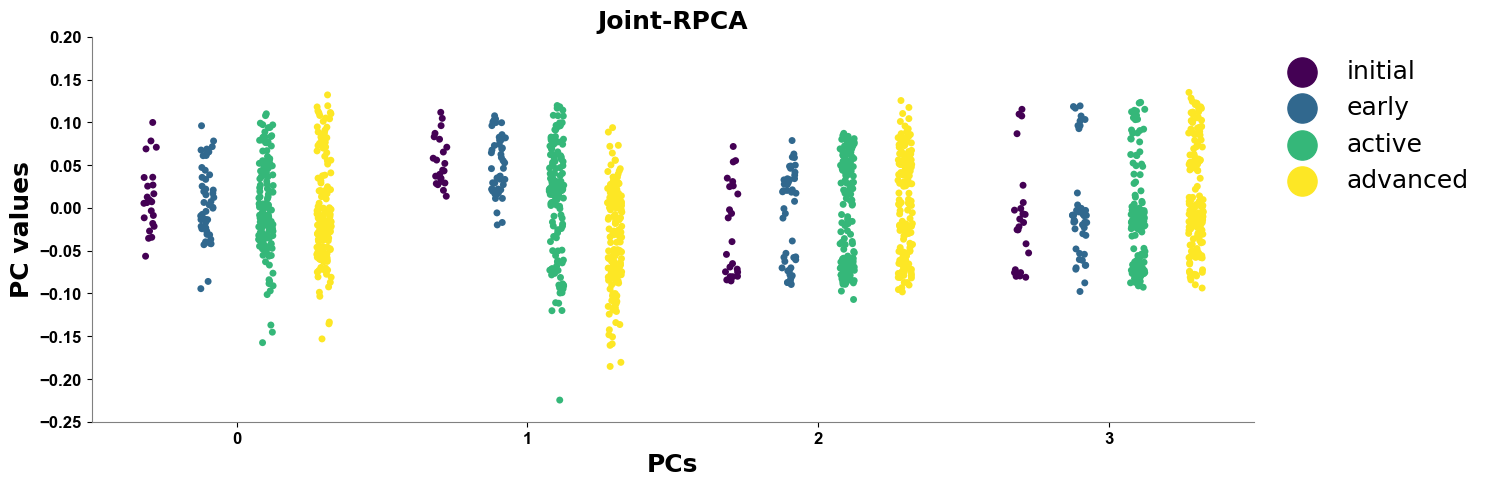

In [43]:
fig, ax = plt.subplots(1,1, figsize=(15, 5))
palette=["#440154FF","#31688EFF","#35B779FF","#FDE725FF"]


ord_plt = ord_jnt.samples
ord_plt = pd.concat({c:pd.concat([ord_plt[[c]].rename({c:'PC'}, axis=1), metadata], axis=1, sort=True).reset_index()
                     for c in ord_plt.columns}, axis=0).reset_index()
sns.stripplot(x='level_0', y='PC', hue='add_0c_group', data=ord_plt, palette=palette,
              hue_order = ['initial', 'early', 'active', 'advanced'], ax=ax, dodge=True)

ax.set_xlabel('PCs',
              color='black',
              weight='bold',
              fontsize=18)
ax.set_ylabel('PC values',
              color='black',
              weight='bold',
              fontsize=18)

ax.set_title('Joint-RPCA',
              color='black',
              weight='bold',
              fontsize=18)

# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)

legend = ax.legend(loc=2, 
           bbox_to_anchor=(1, 1),
           prop={'size':18},
           title="",
           fancybox=True,
                    framealpha=.0,
           ncol=1, markerscale=3.5)
legend.get_title().set_fontsize('16')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
#plt.savefig('../results/figures/rpca-pc-loadings-time.png',
#            dpi=600, 
#            bbox_inches='tight',
#            edgecolor='none')

plt.show()

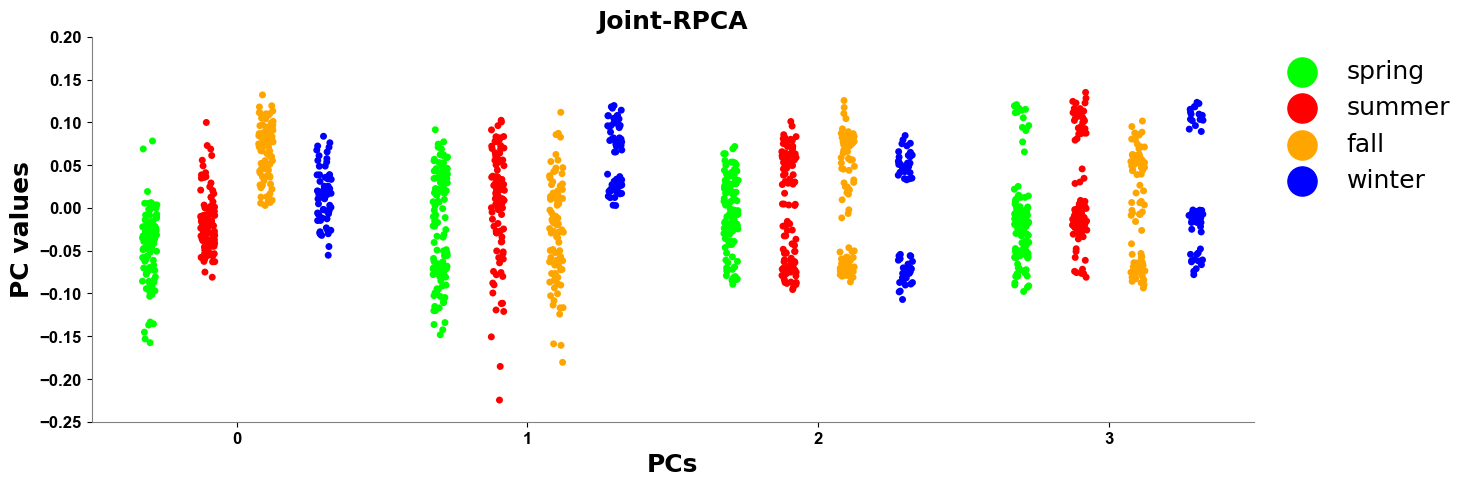

In [44]:
palette=["#00FF00","#FF0000","#FFA500", "#0000FF"]

fig, ax = plt.subplots(1,1, figsize=(15, 5))

ord_plt = ord_jnt.samples
ord_plt = pd.concat({c:pd.concat([ord_plt[[c]].rename({c:'PC'}, axis=1), metadata], axis=1, sort=True).reset_index()
                     for c in ord_plt.columns}, axis=0).reset_index()
#ord_plt = ord_plt[ord_plt["level_0"] != "PC4"]

sns.stripplot(x='level_0', y='PC', hue='season', data=ord_plt,
              hue_order=['spring', 'summer','fall','winter'], 
              palette=palette, ax=ax, dodge=True)

ax.set_xlabel('PCs',
              color='black',
              weight='bold',
              fontsize=18)
ax.set_ylabel('PC values',
              color='black',
              weight='bold',
              fontsize=18)

ax.set_title('Joint-RPCA',
              color='black',
              weight='bold',
              fontsize=18)

# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)

legend = ax.legend(loc=2, 
           bbox_to_anchor=(1, 1),
           prop={'size':18},
           title="",
           fancybox=True,
                    framealpha=.0,
           ncol=1, markerscale=3.5)
legend.get_title().set_fontsize('16')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
#plt.savefig('../results/figures/rpca-pc-loadings-seasons.png',
#            dpi=600, 
#            bbox_inches='tight',
#            edgecolor='none')

plt.show()

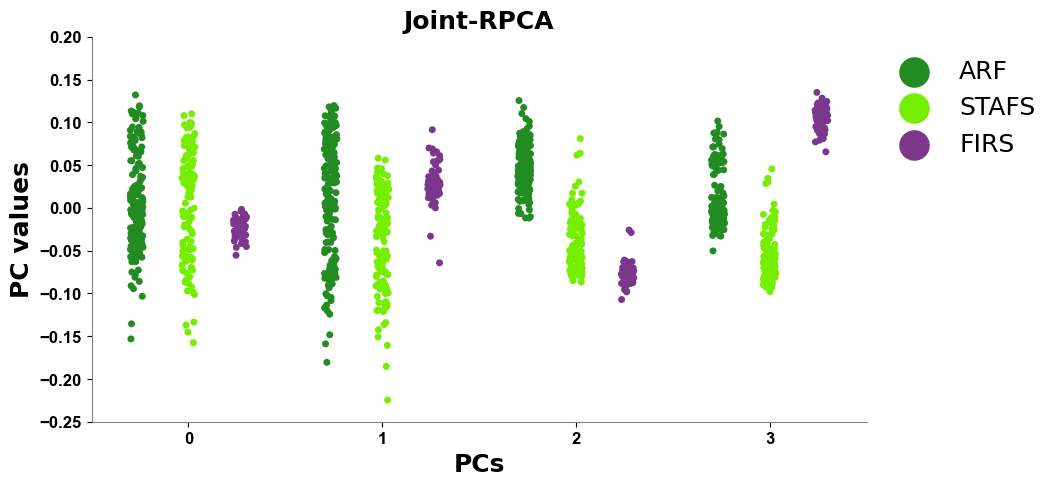

In [45]:
palette=["#228b22","#76ee00","#7a378b"]

fig, ax = plt.subplots(1,1, figsize=(10, 5))

ord_plt = ord_jnt.samples
ord_plt = pd.concat({c:pd.concat([ord_plt[[c]].rename({c:'PC'}, axis=1), metadata], axis=1, sort=True).reset_index()
                     for c in ord_plt.columns}, axis=0).reset_index()

ord_plt = ord_plt[ord_plt["level_0"] != "PC4"]

sns.stripplot(x='level_0', y='PC', hue='facility', hue_order=['ARF', 'STAFS', 'FIRS'], 
              palette=palette, data=ord_plt, ax=ax, dodge=True)

ax.set_xlabel('PCs',
              color='black',
              weight='bold',
              fontsize=18)
ax.set_ylabel('PC values',
              color='black',
              weight='bold',
              fontsize=18)

ax.set_title('Joint-RPCA',
              color='black',
              weight='bold',
              fontsize=18)

# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)

legend = ax.legend(loc=2, 
           bbox_to_anchor=(1, 1),
           prop={'size':18},
           title="",
           fancybox=True,
                    framealpha=.0,
           ncol=1, markerscale=3.5)
legend.get_title().set_fontsize('16')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
#plt.savefig('../results/figures/rpca-pc-loadings-location-PC3.png',
#            dpi=600, 
#            bbox_inches='tight',
#            edgecolor='none')

plt.show()

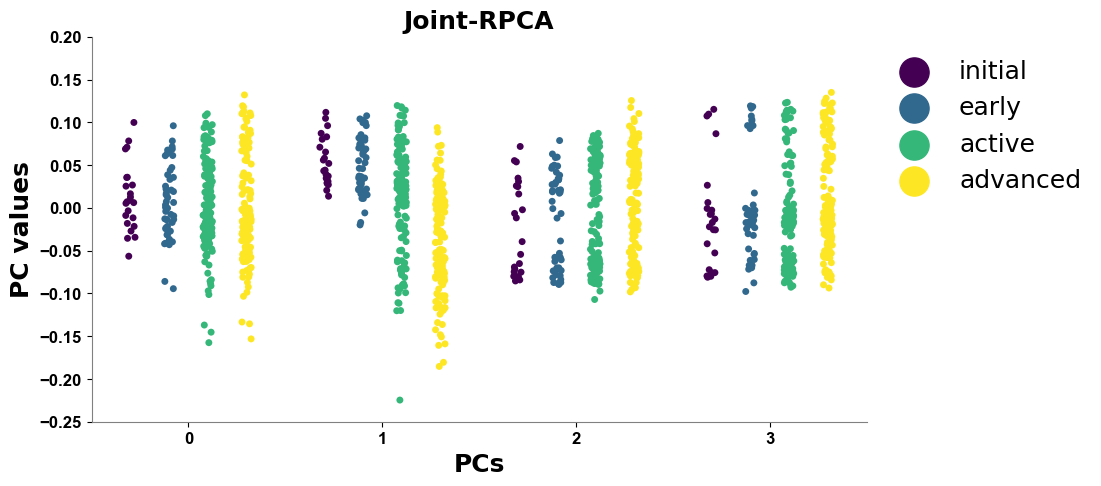

In [46]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))
palette=["#440154FF","#31688EFF","#35B779FF","#FDE725FF"]

ord_plt = ord_jnt.samples
ord_plt = pd.concat({c:pd.concat([ord_plt[[c]].rename({c:'PC'}, axis=1), metadata], axis=1, sort=True).reset_index()
                     for c in ord_plt.columns}, axis=0).reset_index()
ord_plt = ord_plt[ord_plt["level_0"] != "PC4"]

sns.stripplot(x='level_0', y='PC', hue='add_0c_group', data=ord_plt, palette=palette,
              hue_order=['initial', 'early', 'active', 'advanced'], ax=ax, dodge=True)

ax.set_xlabel('PCs',
              color='black',
              weight='bold',
              fontsize=18)
ax.set_ylabel('PC values',
              color='black',
              weight='bold',
              fontsize=18)

ax.set_title('Joint-RPCA',
              color='black',
              weight='bold',
              fontsize=18)

# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)

legend = ax.legend(loc=2, 
           bbox_to_anchor=(1, 1),
           prop={'size':18},
           title="",
           fancybox=True,
                    framealpha=.0,
           ncol=1, markerscale=3.5)
legend.get_title().set_fontsize('16')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
#plt.savefig('../results/figures/rpca-pc-loadings-time-PC3.png',
#            dpi=600, 
#            bbox_inches='tight',
#            edgecolor='none')

plt.show()

### Point plots

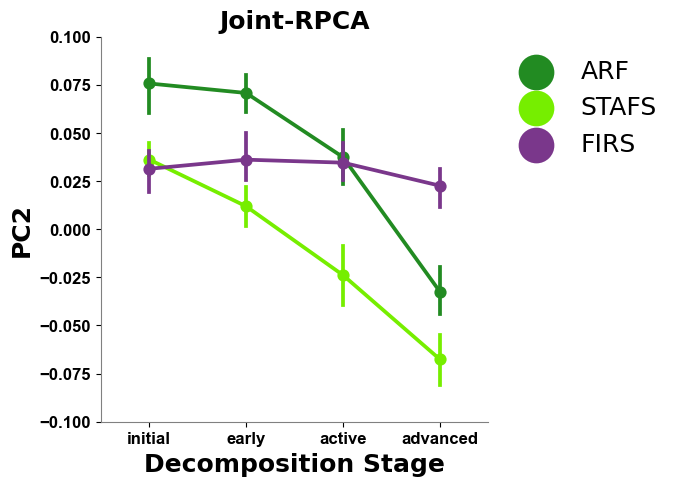

In [47]:
palette=["#228b22","#76ee00","#7a378b"]

fig, ax = plt.subplots(1,1, figsize=(5, 5))
ord_plt = pd.concat([ord_jnt.samples, metadata], axis=1, sort=True)
ord_plt.rename(columns={0:'PC1', 1:'PC2', 2:'PC3'}, inplace=True)
sns.pointplot(x='add_0c_group', y='PC2', hue='facility', hue_order=['ARF', 'STAFS', 'FIRS'], 
              order=['initial', 'early', 'active', 'advanced'],
              data=ord_plt, ax=ax, palette=palette,)

ax.set_xlabel('Decomposition Stage',
              color='black',
              weight='bold',
              fontsize=18)
ax.set_ylabel('PC2',
              color='black',
              weight='bold',
              fontsize=18)

ax.set_title('Joint-RPCA',
              color='black',
              weight='bold',
              fontsize=18)

# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)

legend = ax.legend(loc=2, 
           bbox_to_anchor=(1, 1),
           prop={'size':18},
           title="",
           fancybox=True,
                    framealpha=.0,
           ncol=1, markerscale=3.5)
legend.get_title().set_fontsize('16')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
    
#plt.savefig('../results/figures/rpca-pc2-loadings-location-time.png',
#            dpi=600, 
#            bbox_inches='tight',
#            edgecolor='none')

plt.show()

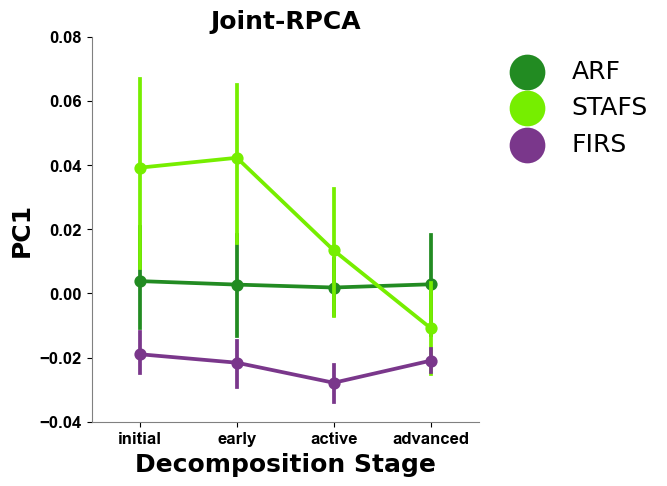

In [48]:
palette=["#228b22","#76ee00","#7a378b"]

fig, ax = plt.subplots(1,1, figsize=(5, 5))
sns.pointplot(x='add_0c_group', y='PC1', hue='facility', hue_order=['ARF', 'STAFS', 'FIRS'], 
              order=['initial', 'early', 'active', 'advanced'],
              data=ord_plt, ax=ax, palette=palette,)

ax.set_xlabel('Decomposition Stage',
              color='black',
              weight='bold',
              fontsize=18)
ax.set_ylabel('PC1',
              color='black',
              weight='bold',
              fontsize=18)

ax.set_title('Joint-RPCA',
              color='black',
              weight='bold',
              fontsize=18)

# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)

legend = ax.legend(loc=2, 
           bbox_to_anchor=(1, 1),
           prop={'size':18},
           title="",
           fancybox=True,
                    framealpha=.0,
           ncol=1, markerscale=3.5)
legend.get_title().set_fontsize('16')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
    
#plt.savefig('../results/figures/rpca-pc1-loadings-location-time.png',
#            dpi=600, 
#            bbox_inches='tight',
#            edgecolor='none')

plt.show()

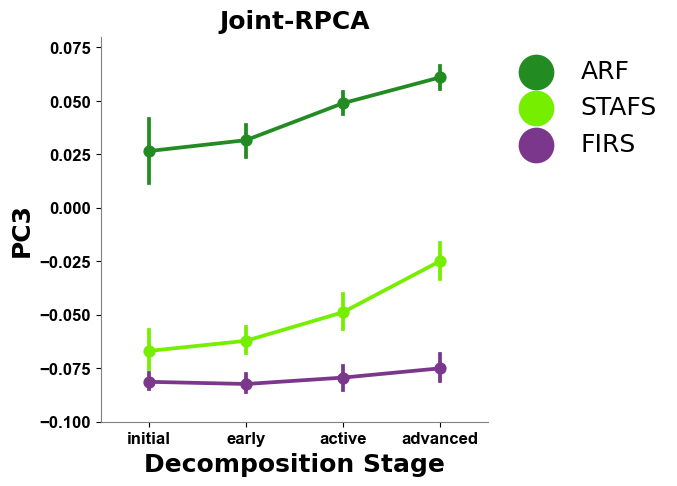

In [49]:
palette=["#228b22","#76ee00","#7a378b"]

fig, ax = plt.subplots(1,1, figsize=(5, 5))
sns.pointplot(x='add_0c_group', y='PC3', hue='facility', 
              hue_order=['ARF', 'STAFS', 'FIRS'], 
              order=['initial', 'early', 'active', 'advanced'],
              data=ord_plt, ax=ax, palette=palette,)

ax.set_xlabel('Decomposition Stage',
              color='black',
              weight='bold',
              fontsize=18)
ax.set_ylabel('PC3',
              color='black',
              weight='bold',
              fontsize=18)

ax.set_title('Joint-RPCA',
              color='black',
              weight='bold',
              fontsize=18)

# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)

legend = ax.legend(loc=2, 
           bbox_to_anchor=(1, 1),
           prop={'size':18},
           title="",
           fancybox=True,
                    framealpha=.0,
           ncol=1, markerscale=3.5)
legend.get_title().set_fontsize('16')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
    
#plt.savefig('../results/figures/rpca-pc3-loadings-location-time.png',
#            dpi=600, 
#            bbox_inches='tight',
#            edgecolor='none')

plt.show()

### Kruskal Wallis

In [50]:
metadata_subset = pd.read_csv('../network/split-matched-data/metadata.tsv', sep='\t', index_col=0)
ord_joint = ord_jnt
#ord_joint = OrdinationResults.read('../results/joint-rpca/Ordinations/joint_ord_{}PCs.txt'.format(n_PCS))
ord_joint_samps = ord_joint.samples.copy()
ord_joint_samps.index.name = 'sample_name'
ord_joint_samps.reset_index(inplace=True)
merged_table = pd.merge(ord_joint_samps, metadata_subset, on='sample_name')
merged_table.head()

sample_name         0         1         2  \
0  soil.hip.SHSU.2016.024.2016.05.03.day19 -0.098698 -0.109510  0.005658   
1   soil.hip.SHSU.2016.076.2016.11.26.day5  0.107789 -0.012081 -0.069731   
2      soil.hip.CMU.17.10.2017.08.28.day20 -0.003416 -0.064283 -0.025962   
3   soil.hip.SHSU.2016.024.2016.04.20.day6 -0.097067 -0.094667 -0.027954   
4    soil.hip.UTK.K016.01.2016.04.16.day12 -0.091080 -0.072832  0.071708   

          3  season       subjects      add_0c add_0c_group facility  ...  \
0 -0.010724  spring  shsu.2016.024  409.166667     advanced    STAFS  ...   
1 -0.075090    fall       2016.076   63.600000       active    STAFS  ...   
2  0.112180  summer          17-10  477.800000     advanced     FIRS  ...   
3 -0.055932  spring  shsu.2016.024  111.666667       active    STAFS  ...   
4  0.001341  spring    UTK.K016.01  141.666667       active      ARF  ...   

   traintest_0 traintest_1 traintest_2 traintest_3 traintest_4 traintest_5  \
0        train       train       train       train       train       train   
1        train       train       train       train       train       train   
2         test        test        test        test        test        test   
3        train       train       train       train       train       train   
4        train       train       train       train       train       train   

  traintest_6 traintest_7 traintest_8 traintest_9  
0       train       train       train       train  
1       train       train       train       train  
2        test        test        test        test  
3       train       train       train       train  
4       train       train       train       train  

[5 rows x 21 columns]

In [52]:
# Group the numerical data based on the categorical data
cats_of_interest = ['facility', 'season', 'add_0c_group']
n_PCS = 4
kw_df_joint = []

for cat_of_interest in cats_of_interest:
    kw_joint_cat = pd.DataFrame()
    kw_h = []
    kw_p = []

    for i in range(n_PCS):
        grouped = merged_table.groupby(cat_of_interest)[i]
        groups = [group for _, group in grouped]

        # Perform the Kruskal-Wallis test
        h, p = kruskal(*groups)
        # print("Facility Kruskal Wallis Tests by Axis")
        # print("Axis ",i+1)
        # print("H-statistic:", h)
        # print("p-value:", p)
        kw_h.append(h)
        kw_p.append(p)

    kw_joint_cat_df = pd.DataFrame(list(zip(kw_h, kw_p)), 
                                   columns = ['H-statistic', 'p-value'],
                                   index=[f'PC{i+1}' for i in range(n_PCS)])
    kw_df_joint.append(kw_joint_cat_df)

kw_df_joint = pd.concat(kw_df_joint, axis=1, keys=cats_of_interest)

In [54]:
#save results
kw_df_joint.to_csv('../results/joint-rpca/Tables/joint_rpca_kw.csv')
kw_df_joint

facility                    season               add_0c_group  \
    H-statistic       p-value H-statistic       p-value  H-statistic   
PC1   14.146955  8.472816e-04  218.486920  4.263785e-47     8.577836   
PC2   63.879984  1.344738e-14   83.797975  4.700570e-18   111.845888   
PC3  280.164284  1.455790e-61    6.056139  1.089107e-01    13.292691   
PC4  267.377664  8.703182e-59   12.179555  6.792722e-03     9.090390   

                   
          p-value  
PC1  3.546368e-02  
PC2  4.395985e-24  
PC3  4.044559e-03  
PC4  2.811293e-02

In [ ]:
# # Group the numerical data based on the categorical data
# for i in range (4):
#     grouped = merged_table.groupby('climate')[i]
#     groups = [group for _, group in grouped]

#     # Perform the Wilcox test
#     u, p = mannwhitneyu(*groups)
#     print("Climate Wilcox Tests by Axis")
#     print("Axis ",i+1)
#     print("U-statistic:", u)
#     print("p-value:", p)